### Importation des librairies

In [896]:
%%capture capt
!pip install lifelines
!pip install tqdm
!pip install numpy==1.22
from tqdm import tqdm
import numpy as np
import pandas as pd
from lifelines.statistics import proportional_hazard_test
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
import statsmodels.stats.diagnostic as diag
import seaborn as sns


### Base cluster unsupervised

In [897]:
profil_patient=pd.read_csv("../data/custom_metric/50_10_1.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient['y_nais']=2016-profil_patient['y_nais']
#Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
#Moyenne empirique du nombre de jours hospitalisé
profil_patient['Nb_jours_moyen']=profil_patient['Nb_jours_sej']/profil_patient['Nb_hospit']
profil_patient.head()

CODE_PATIENT  date_h0  y_nais BEN_RES_DPT  BEN_SEX_COD dte_deces  Mort  \
0           P0     2011      67          11            0       NaN     0   
1           P6     2013      87          14            1   2015-03     1   
2           P8     2015      49          54            1   2015-08     1   
3          P13     2011      57         974            0       NaN     0   
4          P16     2010      69          76            0       NaN     0   

   Nb_survie  Nb_hospit  CHOC  ...  cluster13  cluster14  cluster15  \
0       2596          9     0  ...          0          0          0   
1        456          8     0  ...          0          0          0   
2         41          3     1  ...          0          0          0   
3       2783          2     0  ...          0          0          0   
4       3210          9     0  ...          0          0          0   

   cluster16  cluster17  cluster18  cluster19  cluster20  \
0          0          0          0          0          0   
1          0          0          0          0          0   
2          0          0          0          0          0   
3          0          0          0          0          0   
4          0          0          0          0          0   

                                             p_soins  Nb_jours_moyen  
0  05K051,05M042,05M16T,05M09T,05M092,05C191,05M2...        2.555556  
1  02C05J,02C05J,05M093,04M132,05C222,23M103,04M0...        6.375000  
2                                      11M041,06C194       14.333333  
3                                      05M04T,05K051        1.500000  
4  08C11V,23M15Z,05K102,05M08T,05K102,05C191,23M1...        3.111111  

[5 rows x 36 columns]

### Test Log-Rank

#### Entre clusters non supervisés

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank inter-clusters')

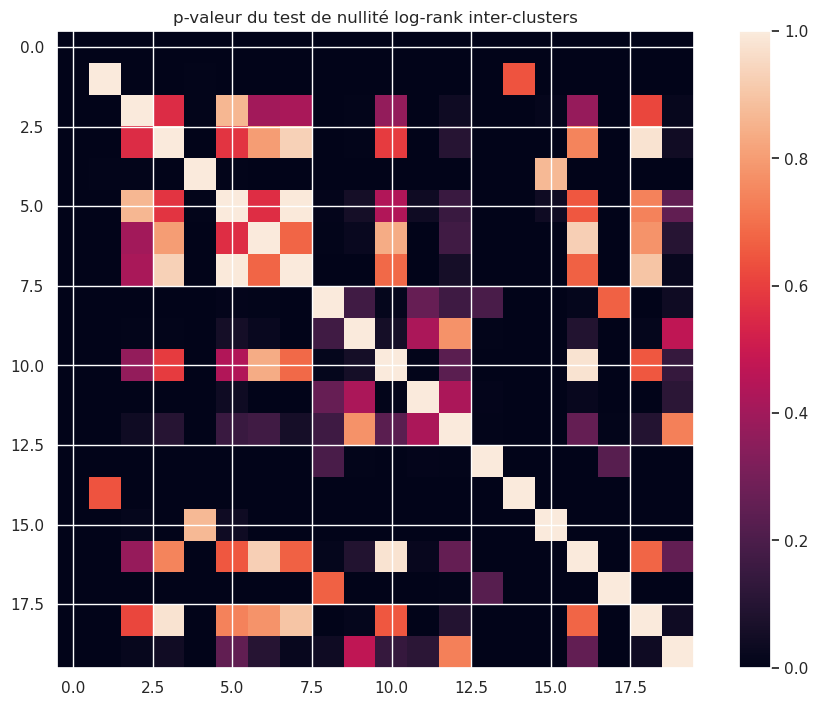

In [898]:
Matrice=np.zeros((20,20))
for i in range (1,20):
    for j in range (1,20):
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['cluster' + str(i)]==1], profil_patient['Nb_survie'][profil_patient['cluster' + str(j)]==1], event_observed_A=profil_patient['Mort'][profil_patient['cluster' + str(i)]==1], event_observed_B=profil_patient['Mort'][profil_patient['cluster' + str(j)]==1])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank inter-clusters")

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank inter-clusters')

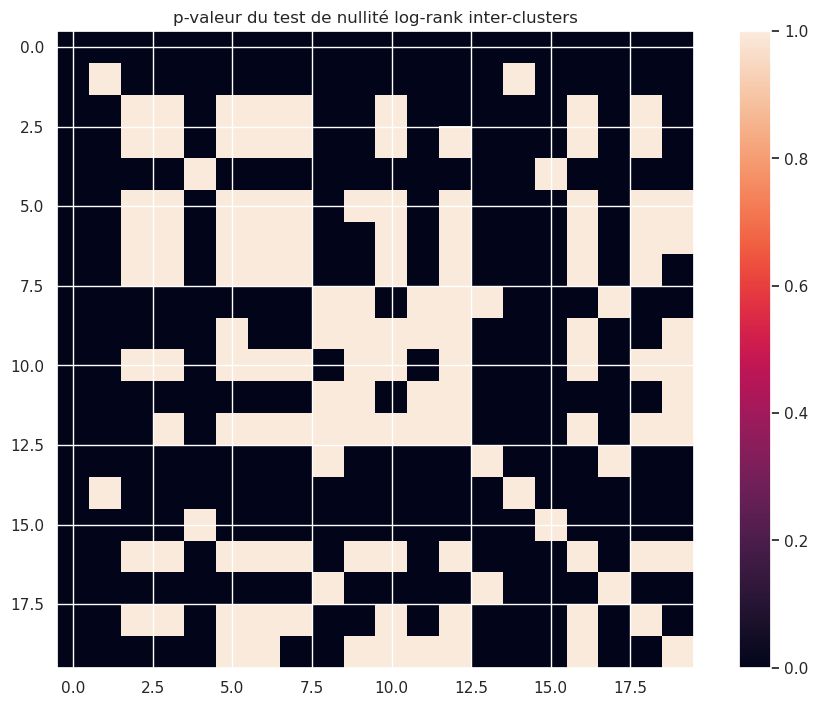

In [899]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank inter-clusters")

#### Choc ou pas choc

p-valeur CHOC/PAS CHOC =
1.0571089917174136e-10


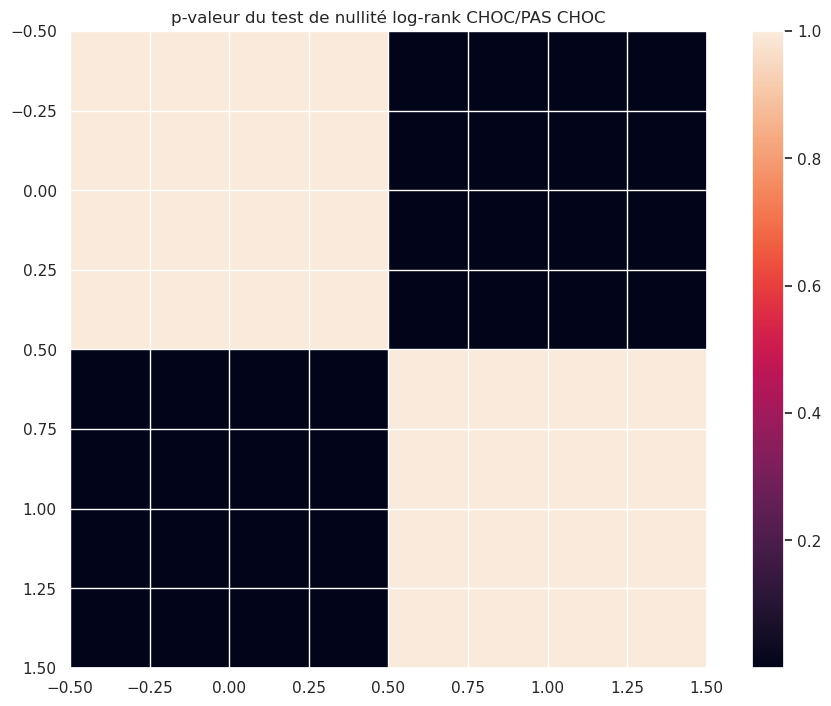

In [900]:
Matrice=np.zeros((2,2))
for i in range (0,2):
    for j in range (0,2):
        cluster_i=i
        cluster_j=j
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['CHOC']==cluster_i], profil_patient['Nb_survie'][profil_patient['CHOC']==cluster_j], event_observed_A=profil_patient['Mort'][profil_patient['CHOC']==cluster_i], event_observed_B=profil_patient['Mort'][profil_patient['CHOC']==cluster_j])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")
print("p-valeur CHOC/PAS CHOC =")
print(logrank_test(profil_patient['Nb_survie'][profil_patient['CHOC']==0], profil_patient['Nb_survie'][profil_patient['CHOC']==1], event_observed_A=profil_patient['Mort'][profil_patient['CHOC']==0], event_observed_B=profil_patient['Mort'][profil_patient['CHOC']==1]).p_value)

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank CHOC/PAS CHOC')

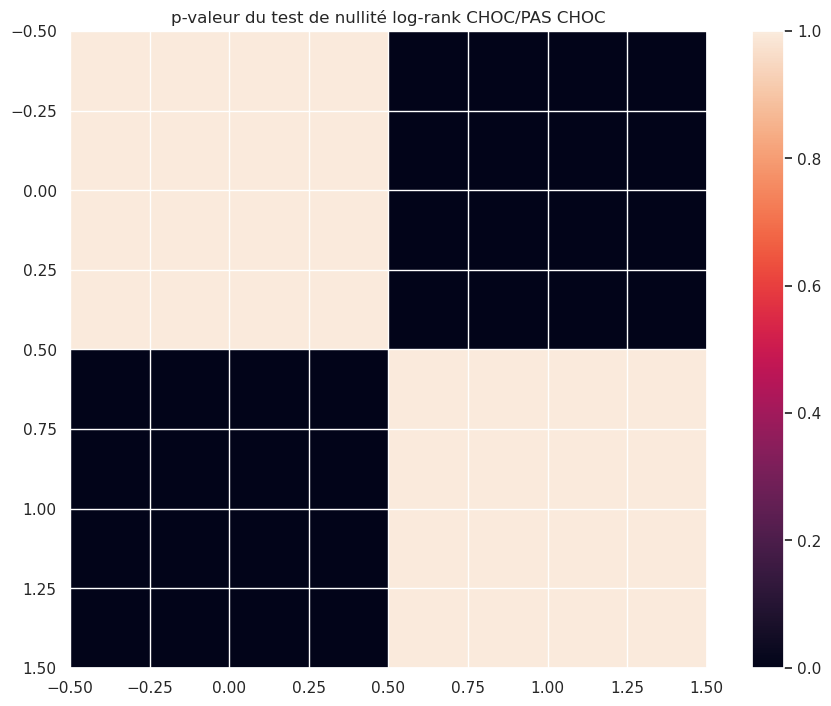

In [36]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")

#### Homme ou femme

In [37]:
Matrice=np.zeros((2,2))
for i in range (0,2):
    for j in range (0,2):
        cluster_i=i+1
        cluster_j=j+1
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==cluster_i], profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==cluster_j], event_observed_A=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==cluster_i], event_observed_B=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==cluster_j])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank HOMME/FEMME")
print("p-valeur HOMME/FEMME =")
print(logrank_test(profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==1], profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==2], event_observed_A=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==1], event_observed_B=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==2]).p_value)

UnboundLocalError: local variable 'survival_table' referenced before assignment

In [ ]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")

### Test COX en extrayant les patients pour chaque cluster

In [1359]:
Nb_cluster=20
profil_patient=pd.read_csv("../data/custom_metric/50_10_1.csv")
profil_patient=profil_patient.dropna()
profil_patient=profil_patient.drop_duplicates()

profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient['y_nais']=2016-profil_patient['y_nais']
#Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
#Moyenne empirique du nombre de jours hospitalisé
profil_patient['Nb_jours_moyen']=profil_patient['Nb_jours_sej']/profil_patient['Nb_hospit']
profil_patient['Nb_jours_moyen']=np.round(profil_patient['Nb_jours_moyen'], 1)
profil_patient=profil_patient.drop(['CODE_PATIENT', 'date_h0', 'BEN_RES_DPT','dte_deces', 'cat_age', 'cat_nb_hospit','cat_nb_jours_sej', 'p_soins', 'Nb_hospit', 'Nb_jours_sej'], axis=1)
profil_patient=profil_patient.dropna()
profil_patient=profil_patient.drop_duplicates()
profil_patient.head()

y_nais  BEN_SEX_COD  Mort  Nb_survie  CHOC  cluster1  cluster2  cluster3  \
1      87            1     1        456     0         0         0         0   
2      49            1     1         41     1         1         0         0   
5      83            1     1        905     0         0         0         0   
6      83            1     1        938     0         0         0         0   
9      49            0     1       2489     0         0         0         0   

   cluster4  cluster5  ...  cluster12  cluster13  cluster14  cluster15  \
1         0         0  ...          0          0          0          0   
2         0         0  ...          0          0          0          0   
5         0         0  ...          0          0          0          0   
6         0         0  ...          0          0          0          0   
9         0         0  ...          0          0          0          0   

   cluster16  cluster17  cluster18  cluster19  cluster20  Nb_jours_moyen  
1          0          0          0          0          0             6.4  
2          0          0          0          0          0            14.3  
5          0          1          0          0          0             7.6  
6          0          0          0          0          0            11.9  
9          0          1          0          0          0             2.0  

[5 rows x 26 columns]

In [1360]:
data_train, data_test = train_test_split(profil_patient, 
                                                    test_size=0.2)


In [1361]:
data_train.head()

y_nais  BEN_SEX_COD  Mort  Nb_survie  CHOC  cluster1  cluster2  \
4617      91            1     1        410     0         1         0   
7624      79            1     1       1502     0         1         0   
8941      85            1     1        111     0         0         0   
9358      91            1     1         38     0         1         0   
9601      83            1     1        308     0         0         0   

      cluster3  cluster4  cluster5  ...  cluster12  cluster13  cluster14  \
4617         0         0         0  ...          0          0          0   
7624         0         0         0  ...          0          0          0   
8941         0         0         0  ...          0          0          0   
9358         0         0         0  ...          0          0          0   
9601         0         0         0  ...          0          0          0   

      cluster15  cluster16  cluster17  cluster18  cluster19  cluster20  \
4617          0          0          0          0          0          0   
7624          0          0          0          0          0          0   
8941          0          0          0          0          0          0   
9358          0          0          0          0          0          0   
9601          0          0          0          0          0          0   

      Nb_jours_moyen  
4617             6.0  
7624            20.0  
8941            15.1  
9358             8.5  
9601            11.4  

[5 rows x 26 columns]

In [1362]:
def extract_cluster_i(i,data,Nb_cluster):
    data_train_cluster=data[data['cluster' + str(i)]==1].copy()
    for j in range(1,Nb_cluster+1):
        data_train_cluster=data_train_cluster.drop(['cluster' + str(j)], axis=1)
    data_train_cluster=data_train_cluster.drop_duplicates()
    data_train_cluster=data_train_cluster.dropna()
    return data_train_cluster

In [1363]:
data_train_cluster= extract_cluster_i(1,data_train, Nb_cluster)
data_train_cluster

y_nais  BEN_SEX_COD  Mort  Nb_survie  CHOC  Nb_jours_moyen
4617      91            1     1        410     0             6.0
7624      79            1     1       1502     0            20.0
9358      91            1     1         38     0             8.5
9852      88            0     1          5     0             4.0
6011      96            1     1        316     0            18.5
...      ...          ...   ...        ...   ...             ...
7413      95            1     1        715     0            11.5
2074      93            1     1        260     0             5.5
5829      85            1     1       1517     0             4.0
465       87            0     1         26     0            26.0
2255      79            1     1        884     0            48.0

[630 rows x 6 columns]

In [1364]:
%%capture capt
#On définit nos variables
Variables=['y_nais','BEN_SEX_COD','CHOC','Nb_jours_moyen']
Variables_sans_CHOC=['y_nais','BEN_SEX_COD','Nb_jours_moyen']
data_train_cluster= extract_cluster_i(1,data_train, Nb_cluster)

if data_train_cluster['CHOC'].nunique()==1:
    data_train_cluster=data_train_cluster.drop(['CHOC'], axis=1)

cph = CoxPHFitter()
cph.fit(data_train_cluster, duration_col='Nb_survie', event_col='Mort')

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))

if data_train_cluster['CHOC'].nunique()==1:
    var=Variables_sans_CHOC
    #Courbe de survie:
    cph.plot_partial_effects_on_outcome(covariates=['BEN_SEX_COD'], values=[0,1], cmap='coolwarm', ax=ax1)
    fig.suptitle("Courbe de survie pour le cluster : " + str(1))
else:
    var=Variables
    #Courbe de survie:
    cph.plot_partial_effects_on_outcome(covariates=['BEN_SEX_COD','CHOC'], values=[(0,0),(1,0),(0,1),(1,1)], cmap='coolwarm', ax=ax1)
    fig.suptitle("Courbe de survie pour le cluster : " + str(1))
    
#Courbe de survie:
Liste_quantile=[0,.25, .5, .75,1]
Age=data_train_cluster['y_nais'].quantile(Liste_quantile)
Nb_jours=data_train_cluster['Nb_jours_moyen'].quantile([0,.25, .5, .75,1])
cph.plot_partial_effects_on_outcome(covariates=['y_nais'], values=Age, cmap='coolwarm', ax=ax2)

#Courbe de survie:
Liste_quantile=[0,.25, .5, .75,1]
Nb_jours=data_train_cluster['Nb_jours_moyen'].quantile([0,.25, .5, .75,1])
cph.plot_partial_effects_on_outcome(covariates=['Nb_jours_moyen'], values=Nb_jours, cmap='coolwarm', ax=ax3)

#Use Lifelines to calculate the variance scaled Schoenfeld residuals for all regression variables in one go:
scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train_cluster, kind='scaled_schoenfeld')
for variable in var:
    result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[5], boxpierce=True, model_df=0, period=None, return_df=None)
    


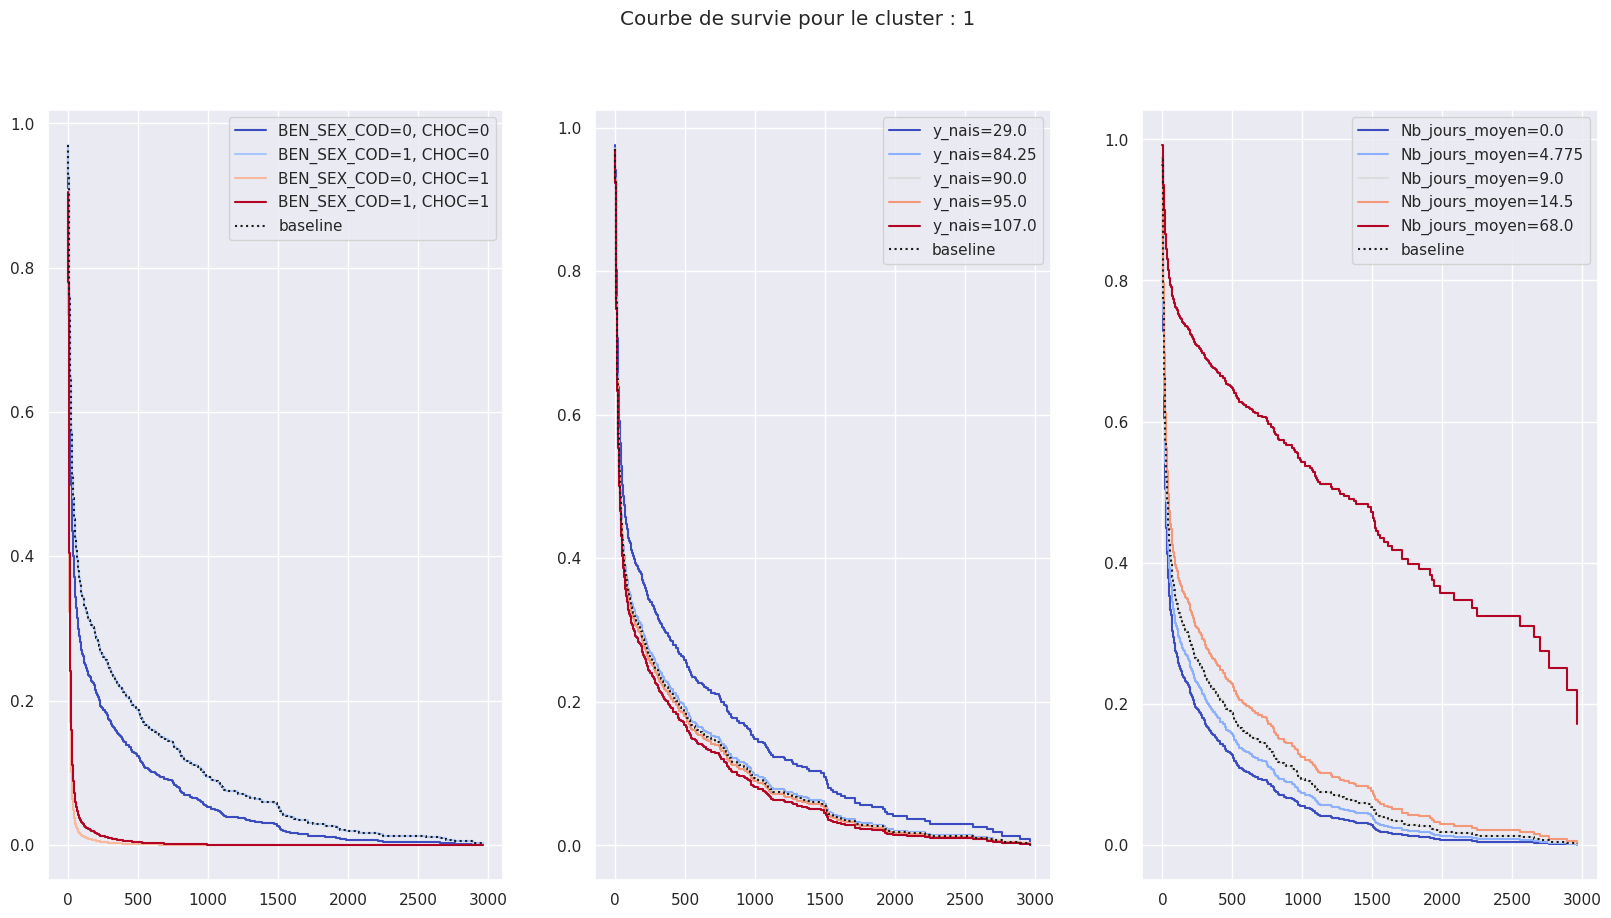

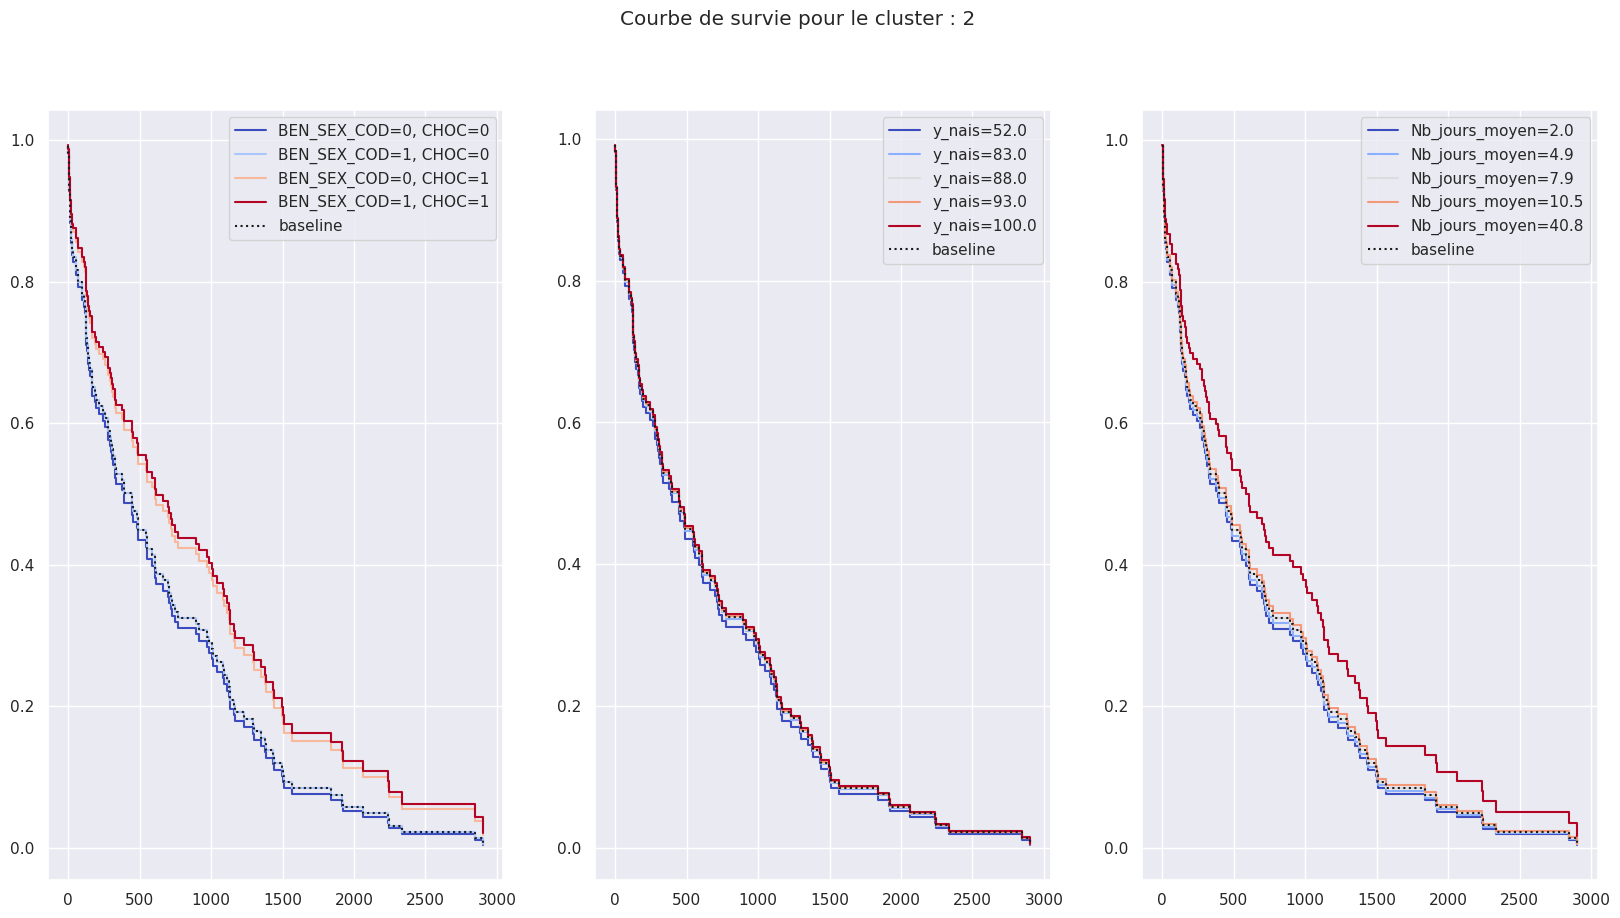

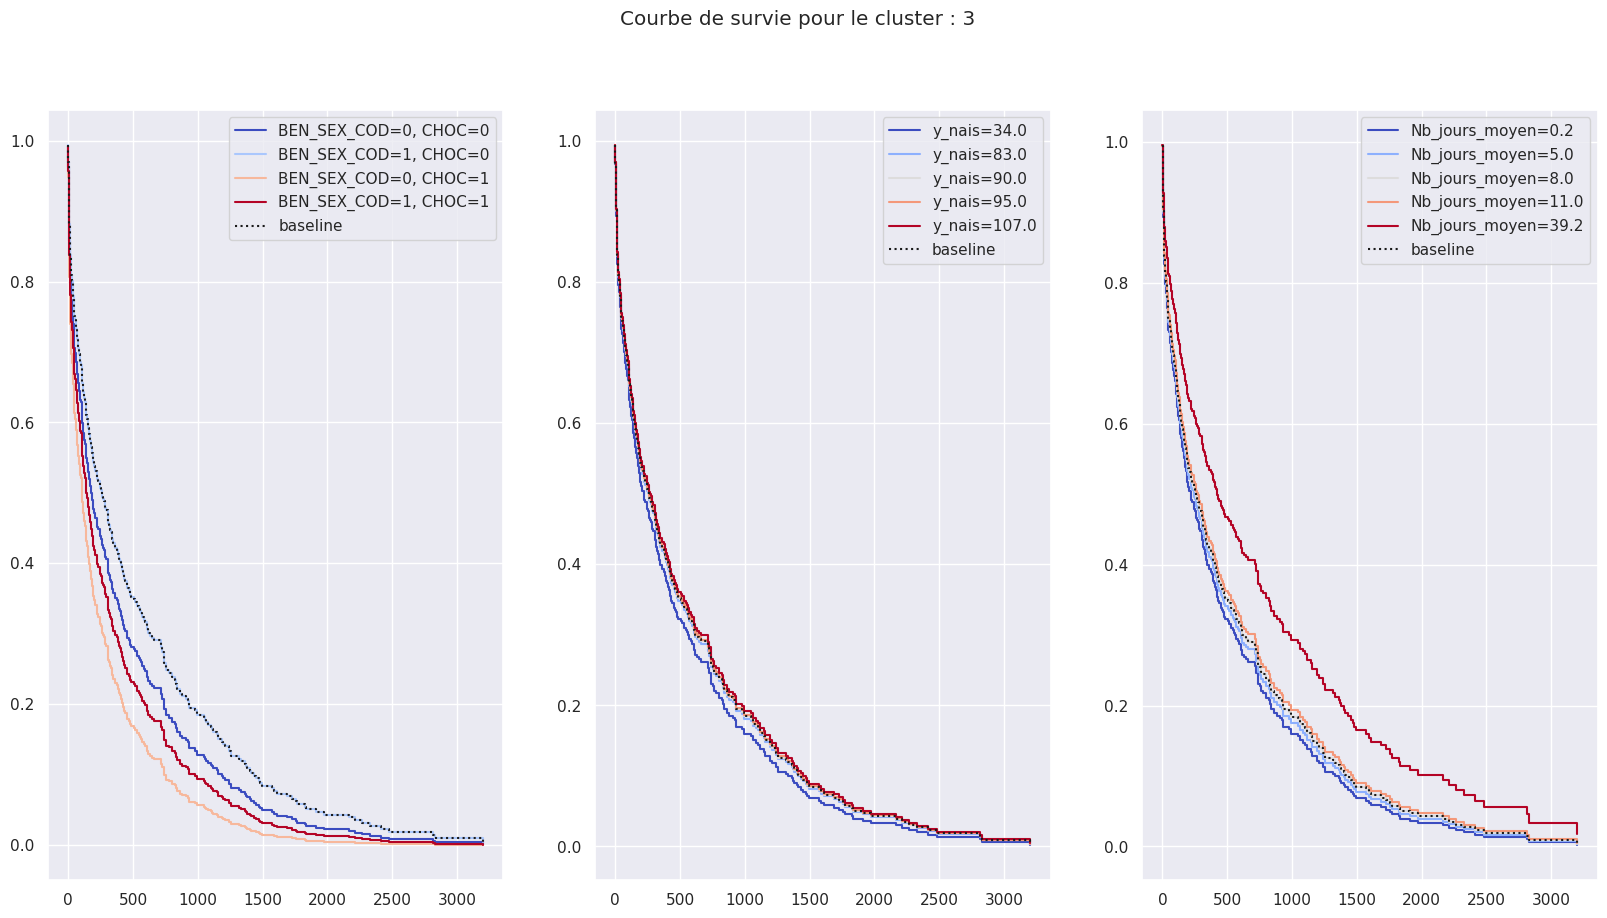

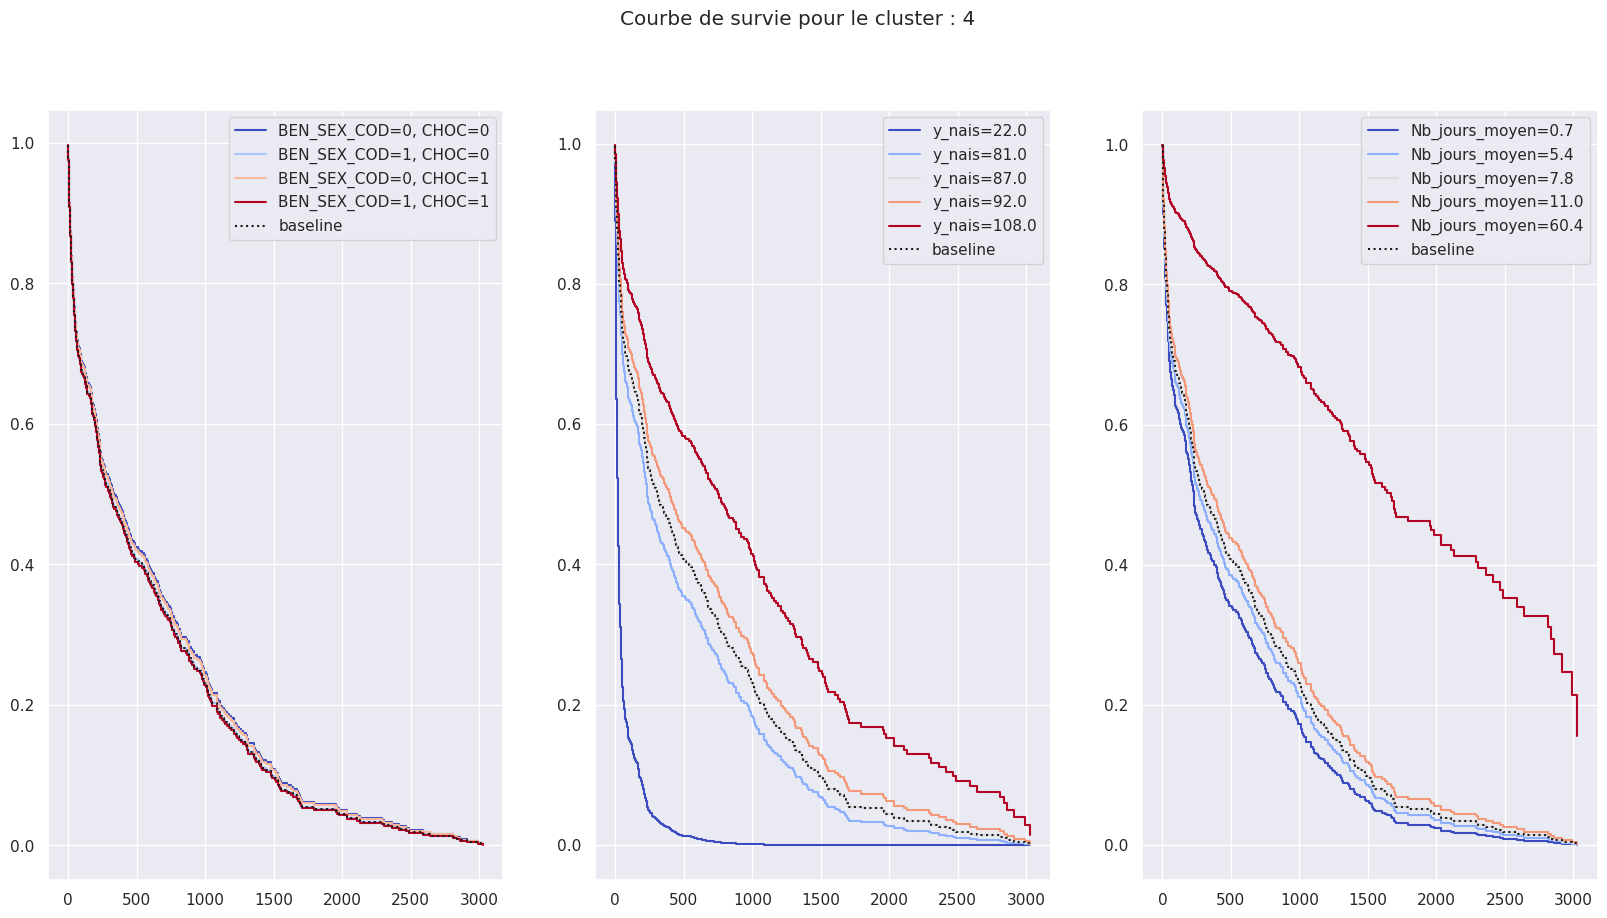

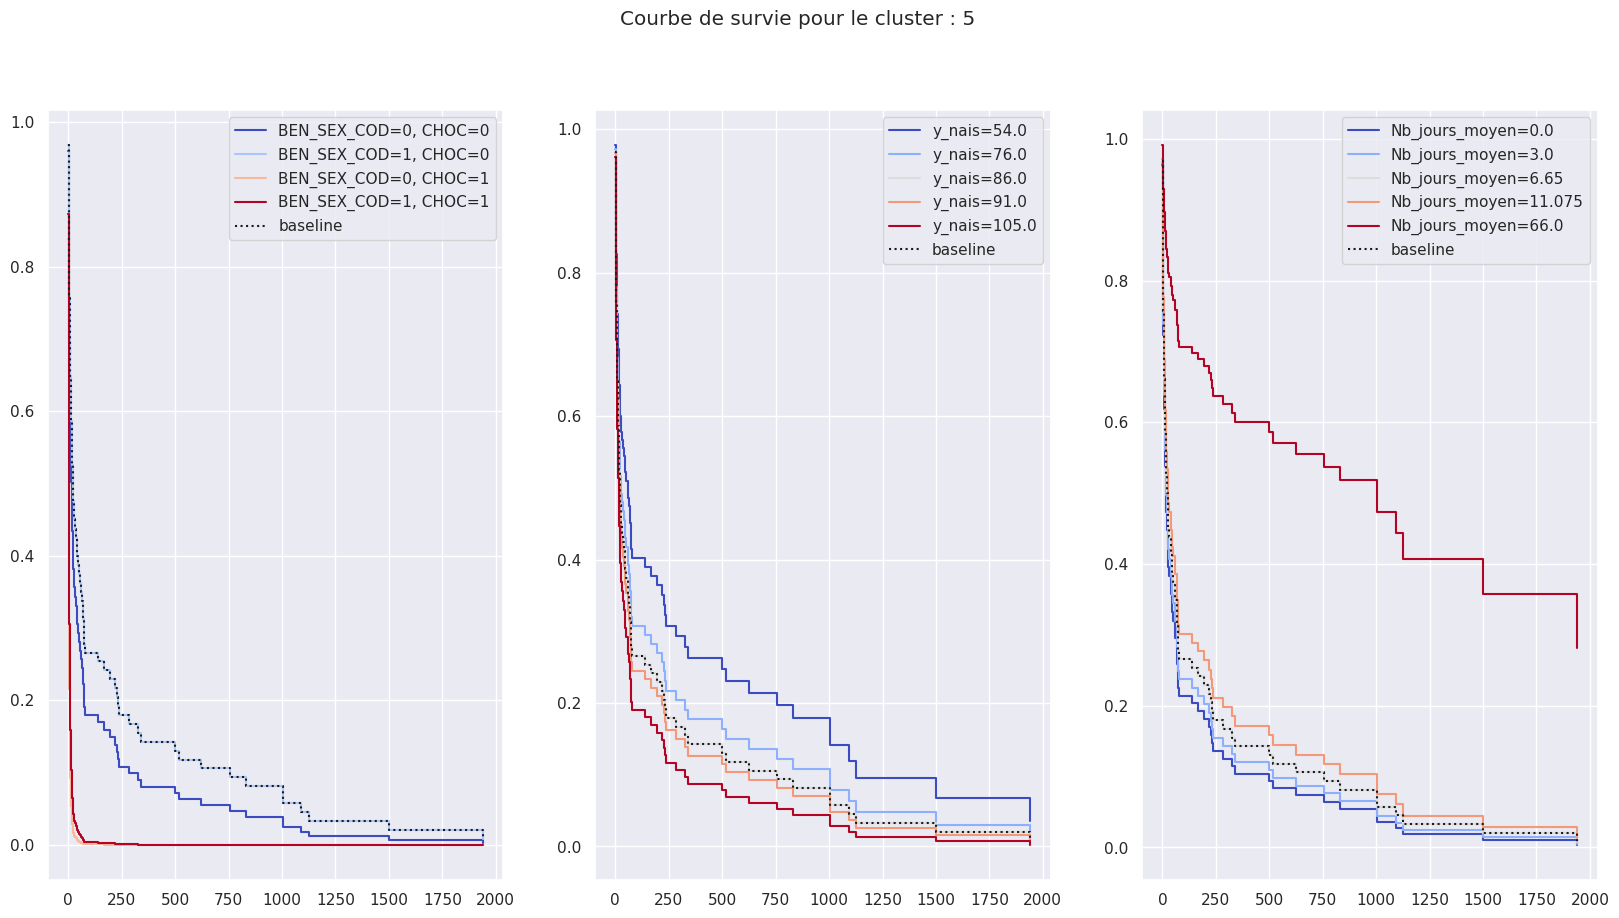

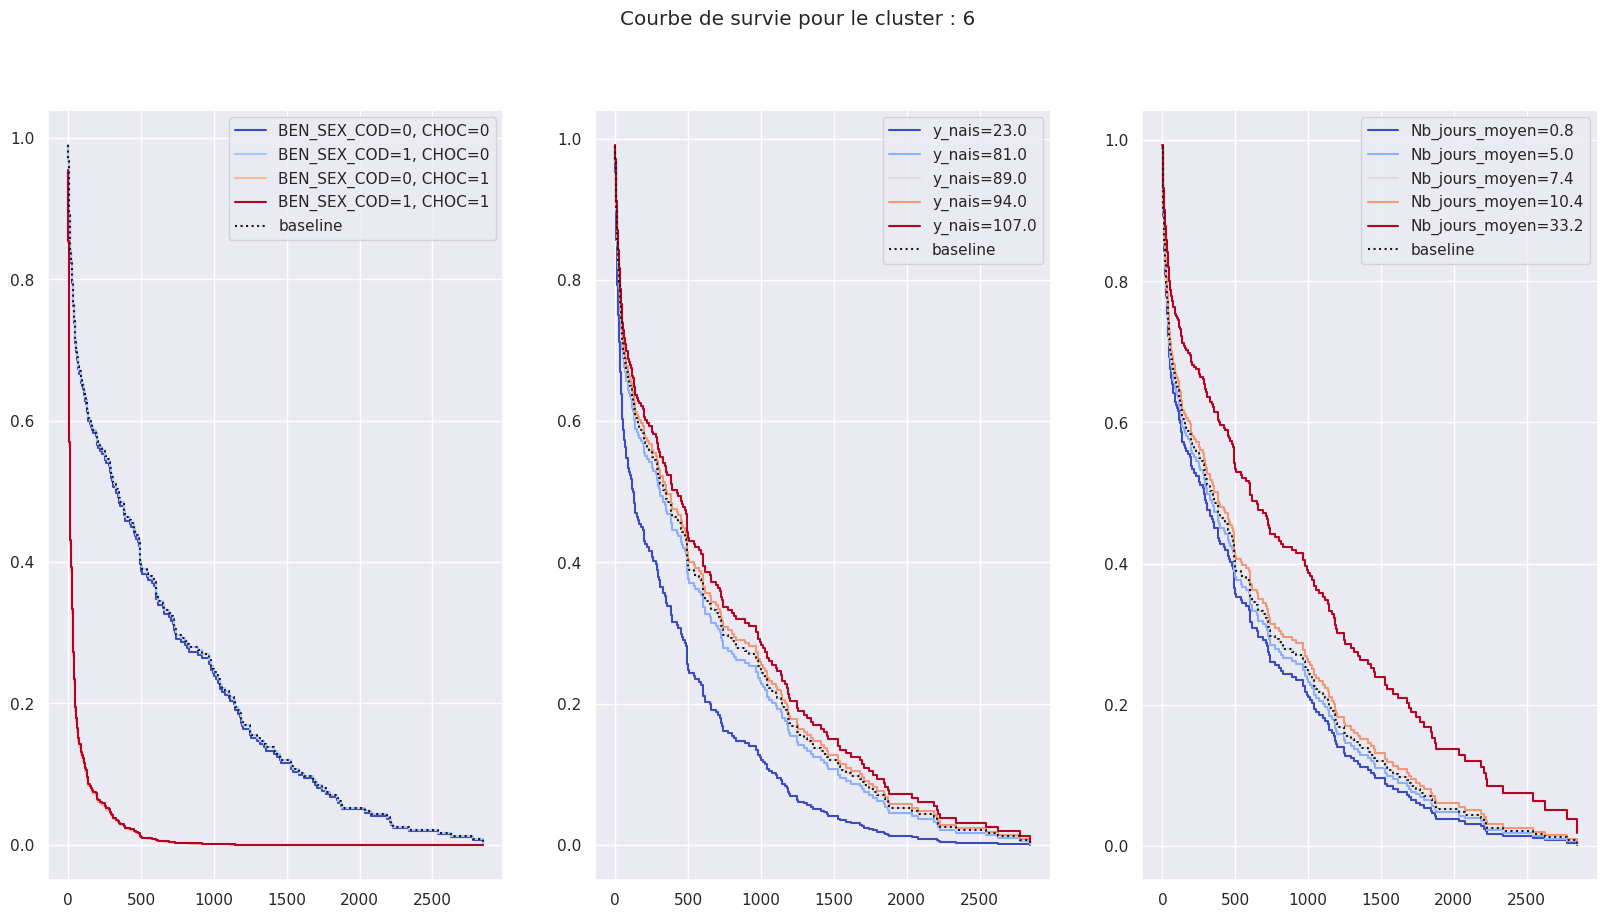

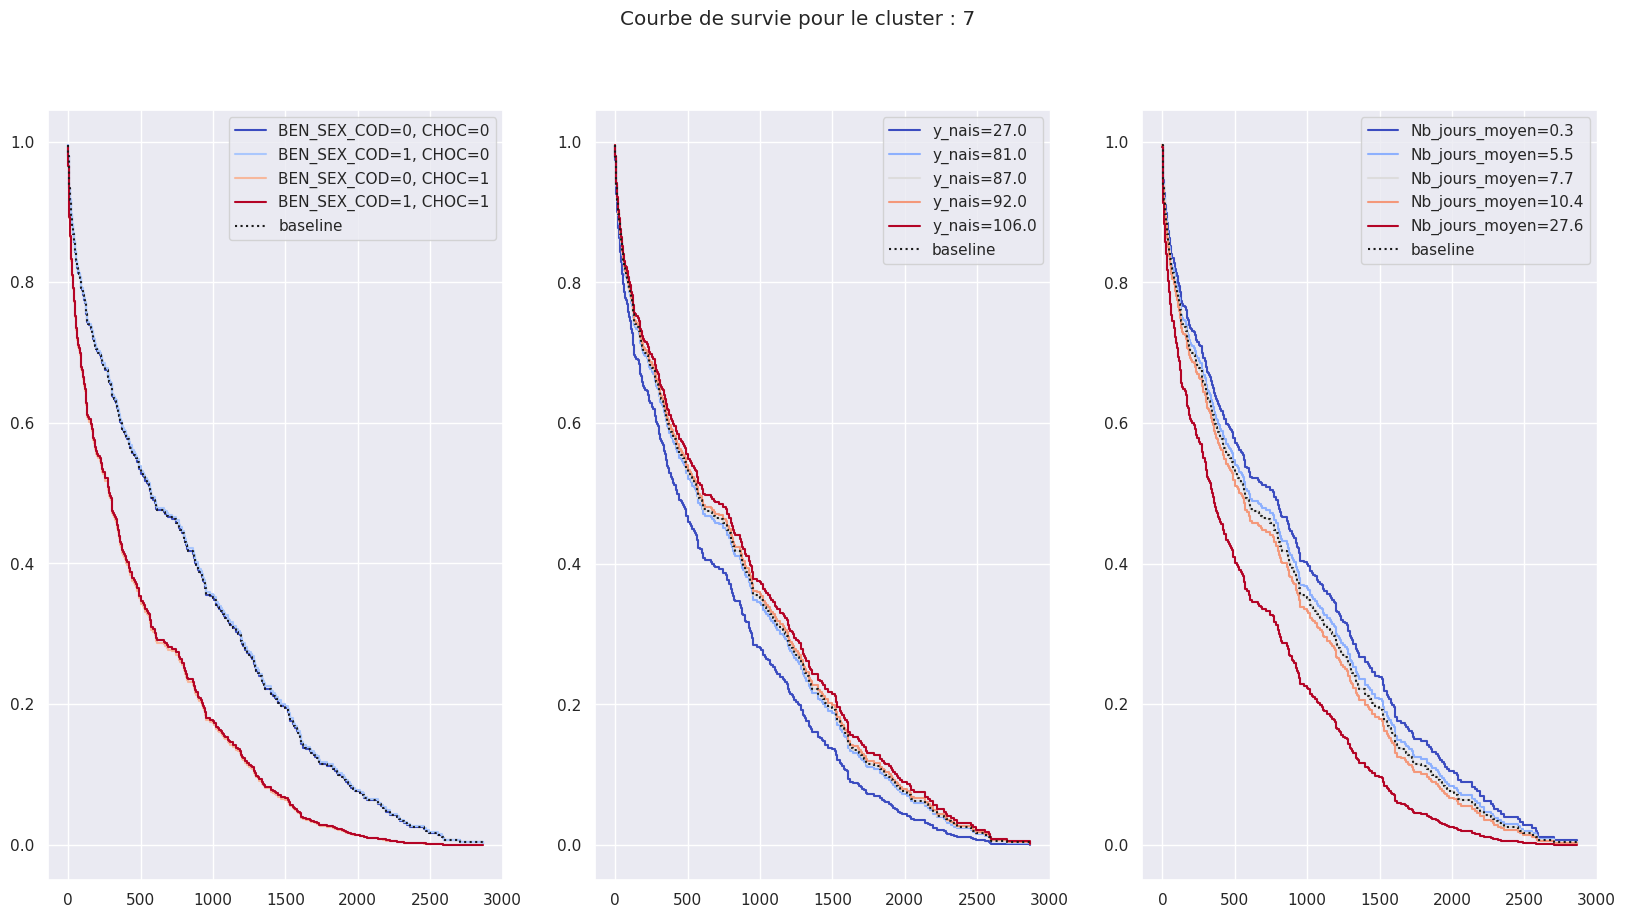

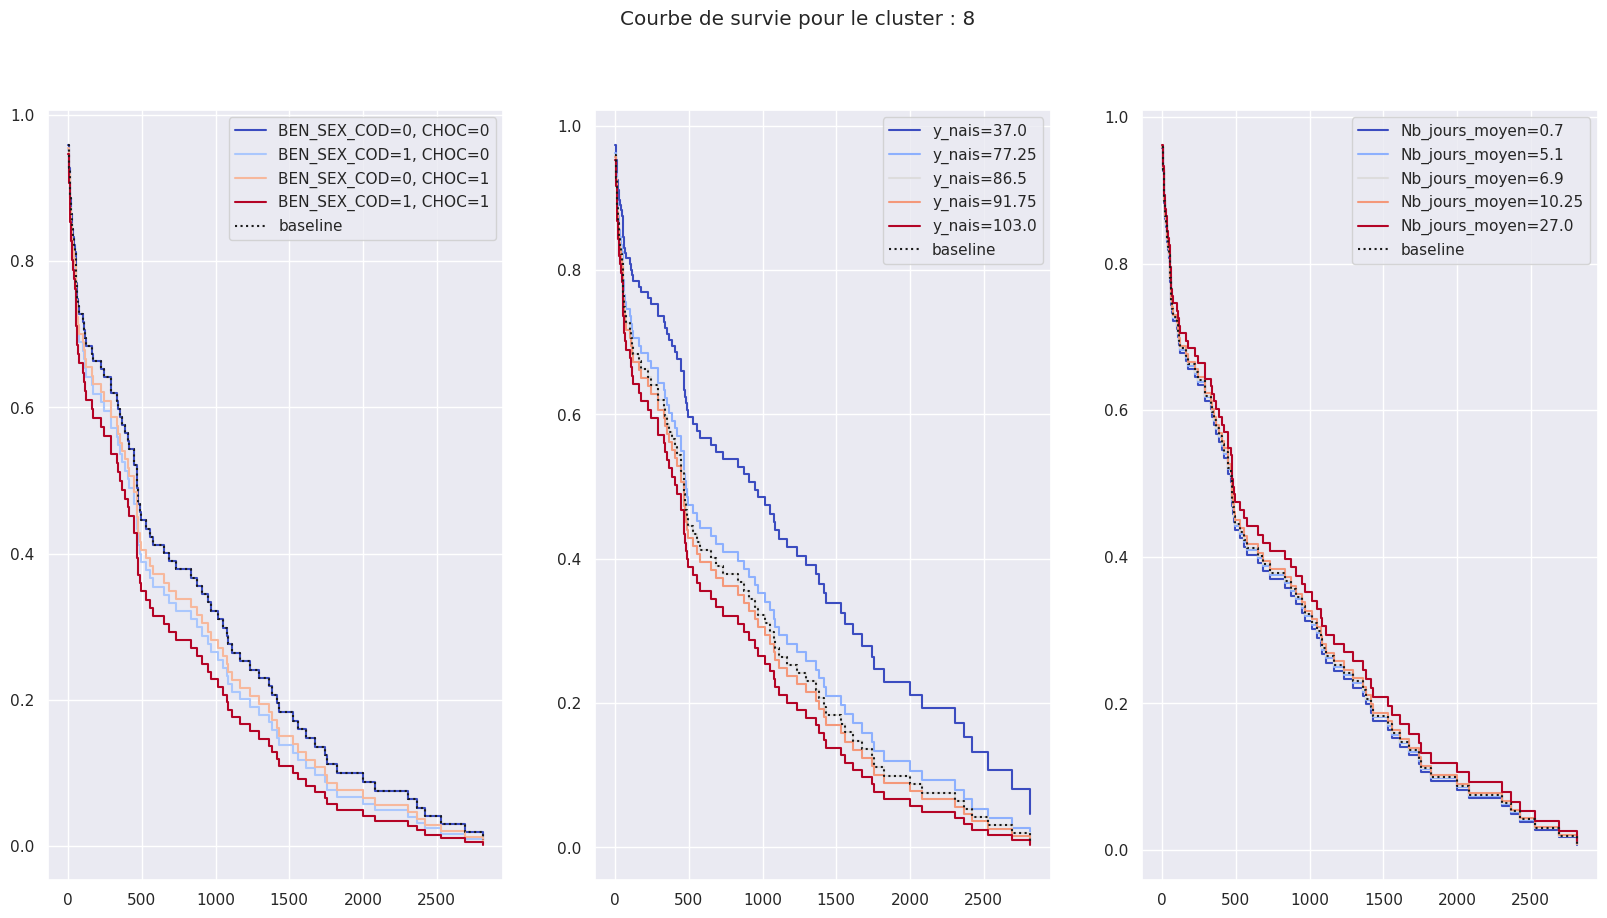

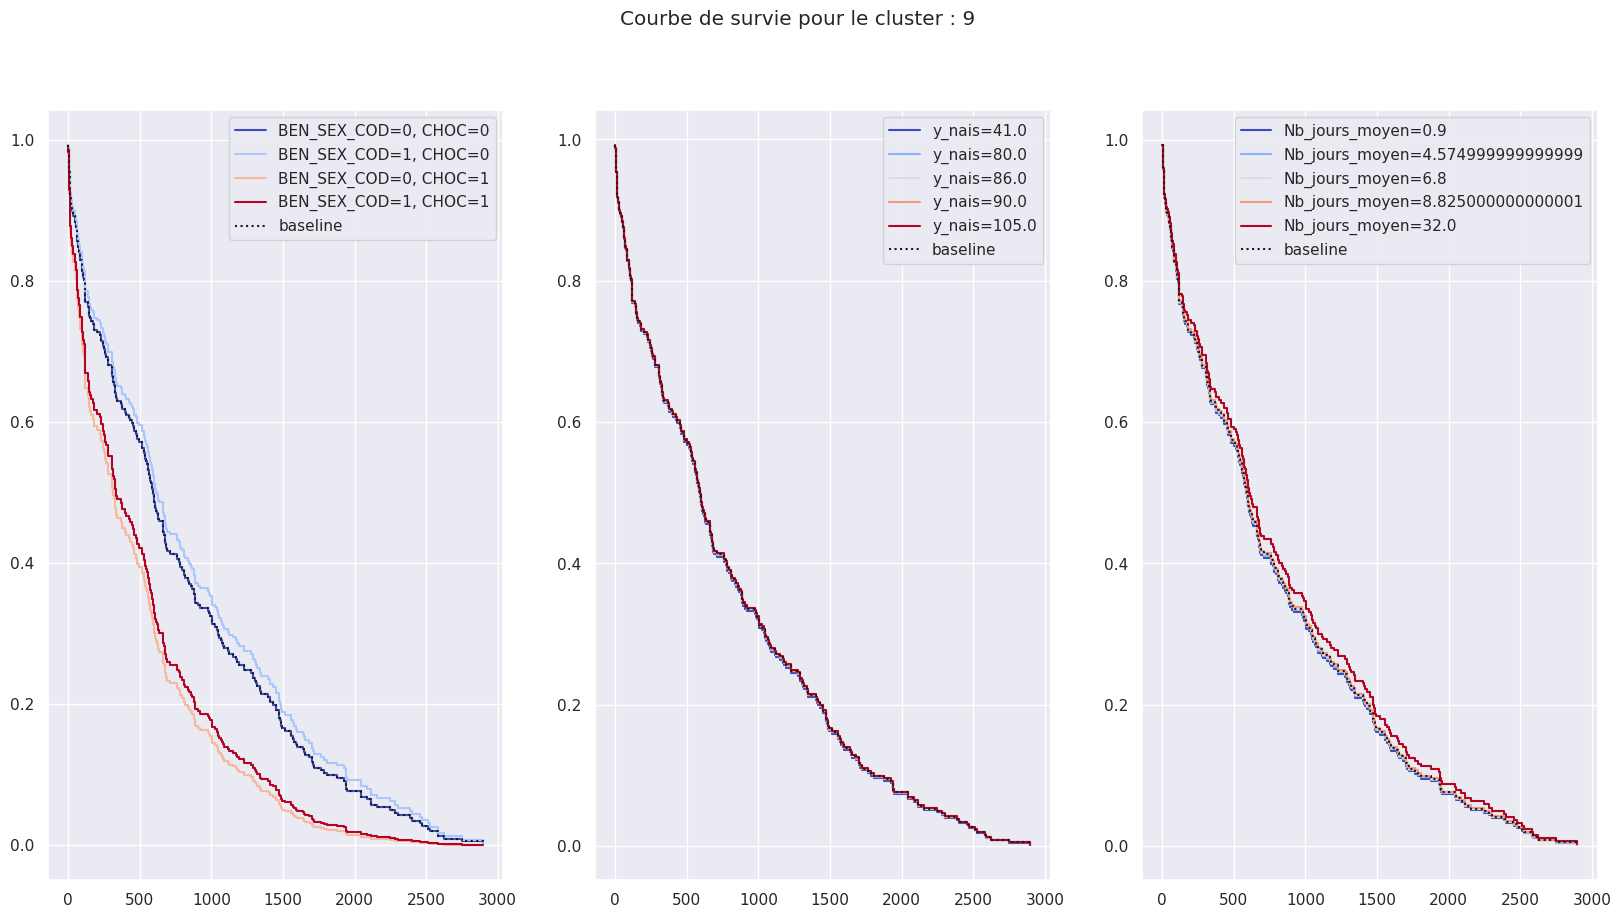

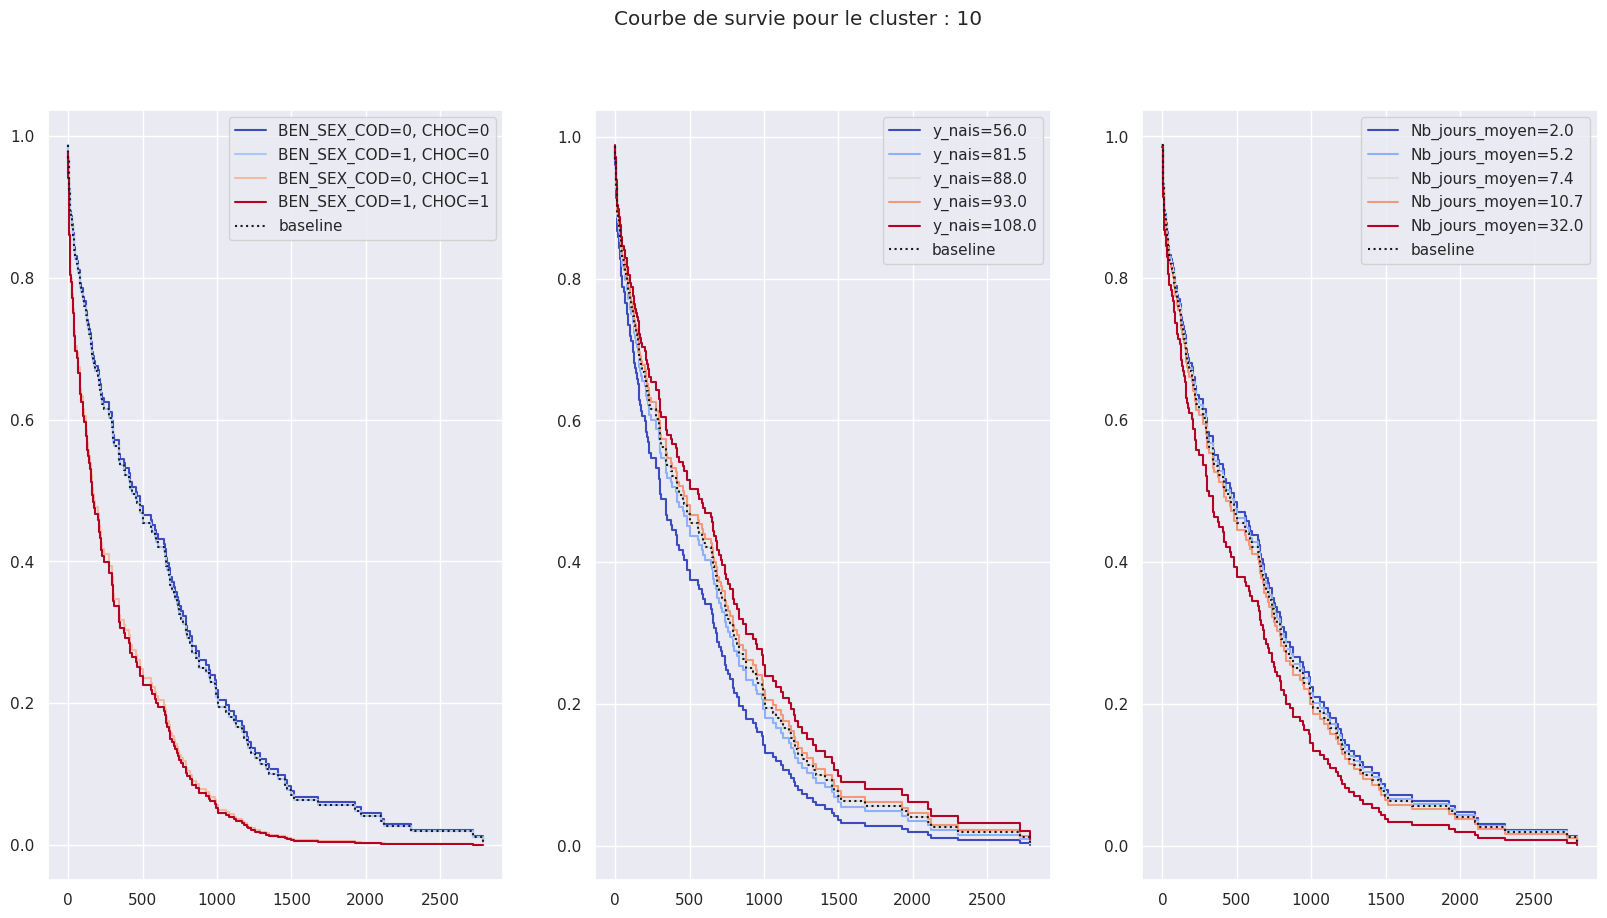

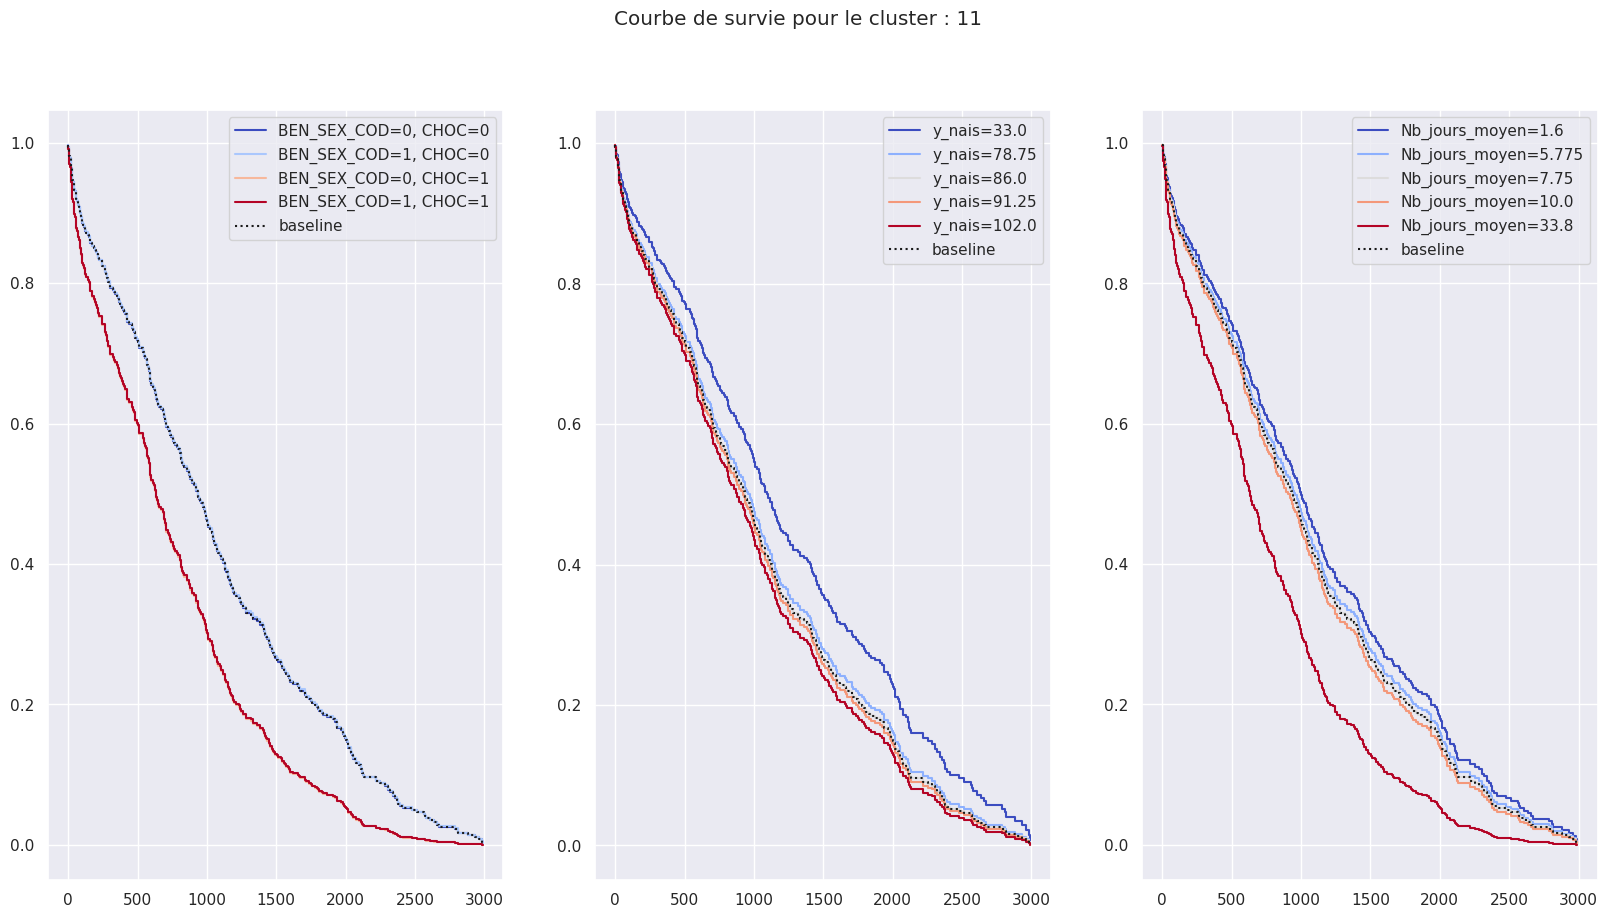

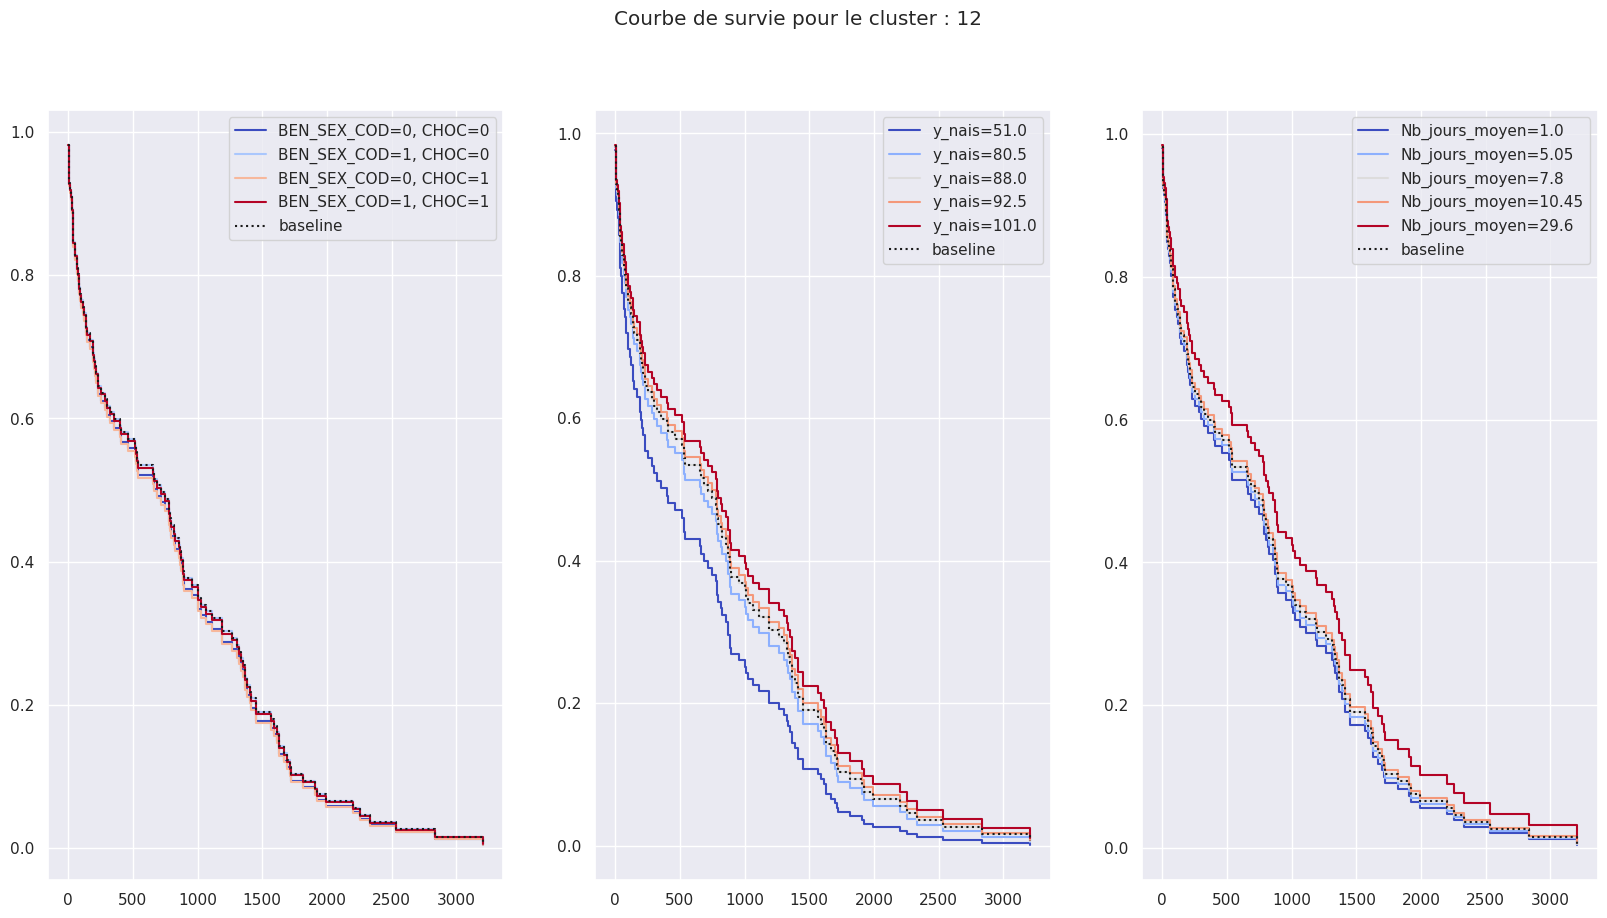

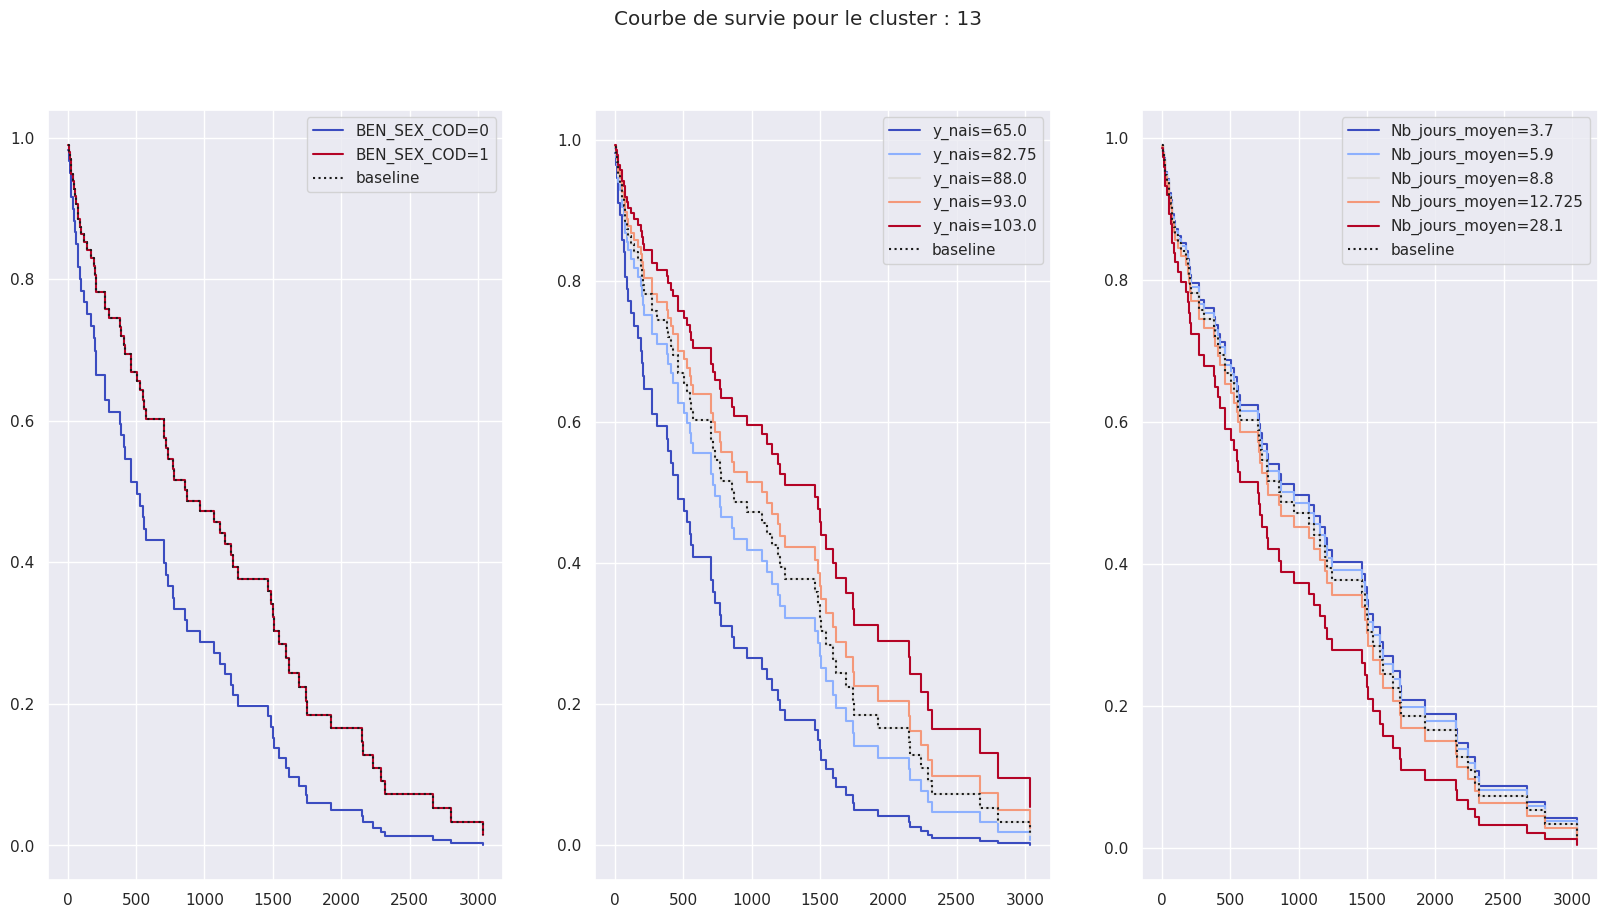

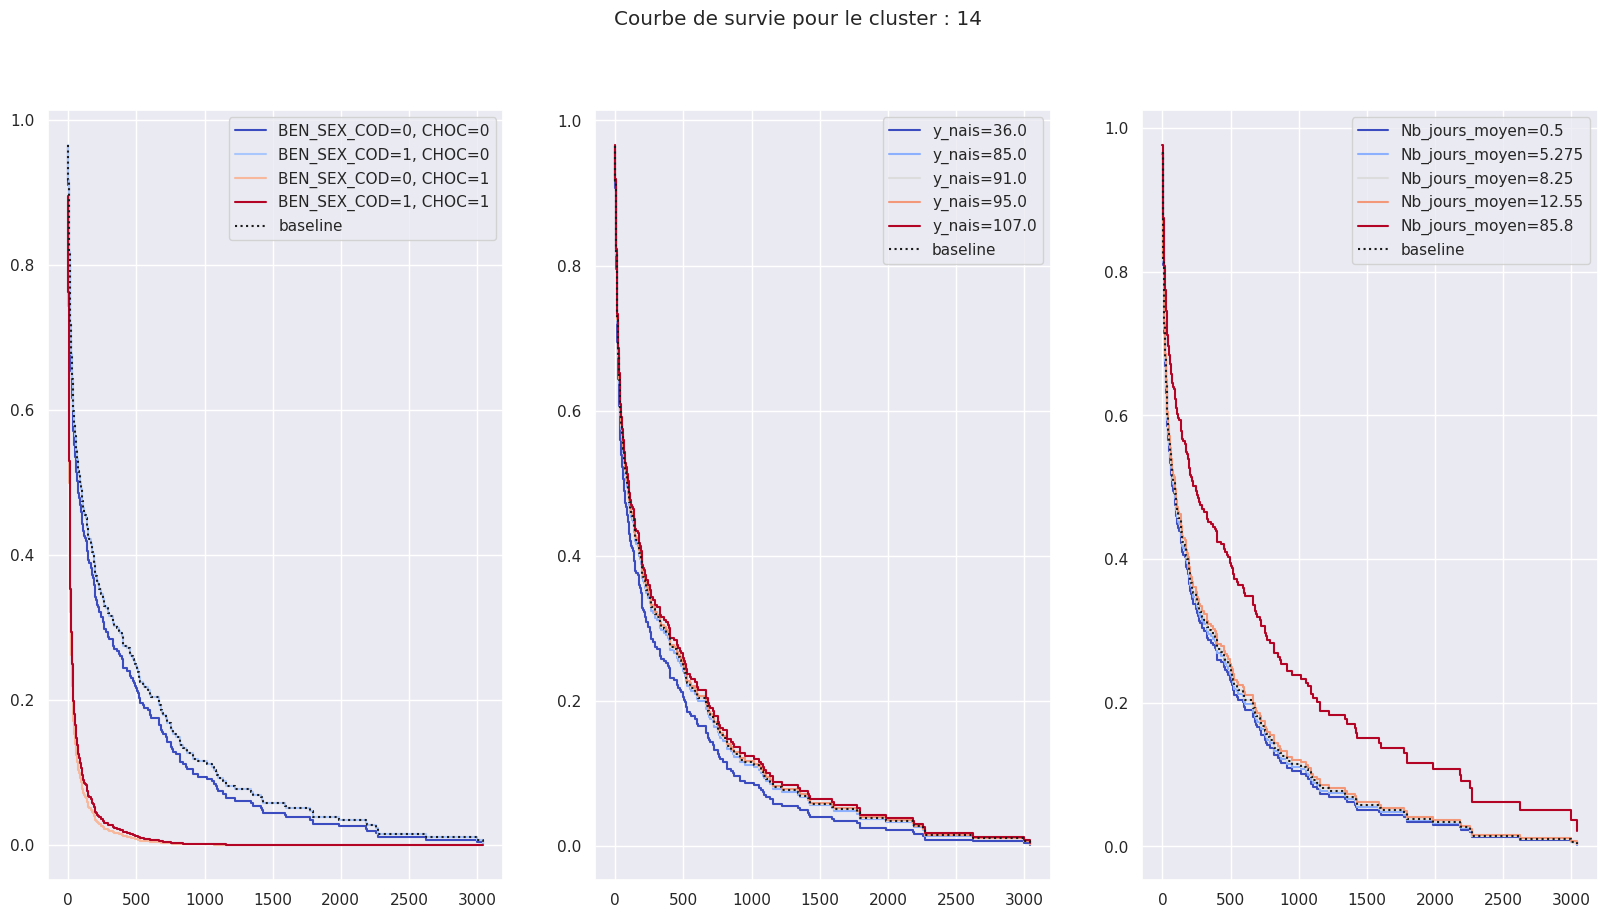

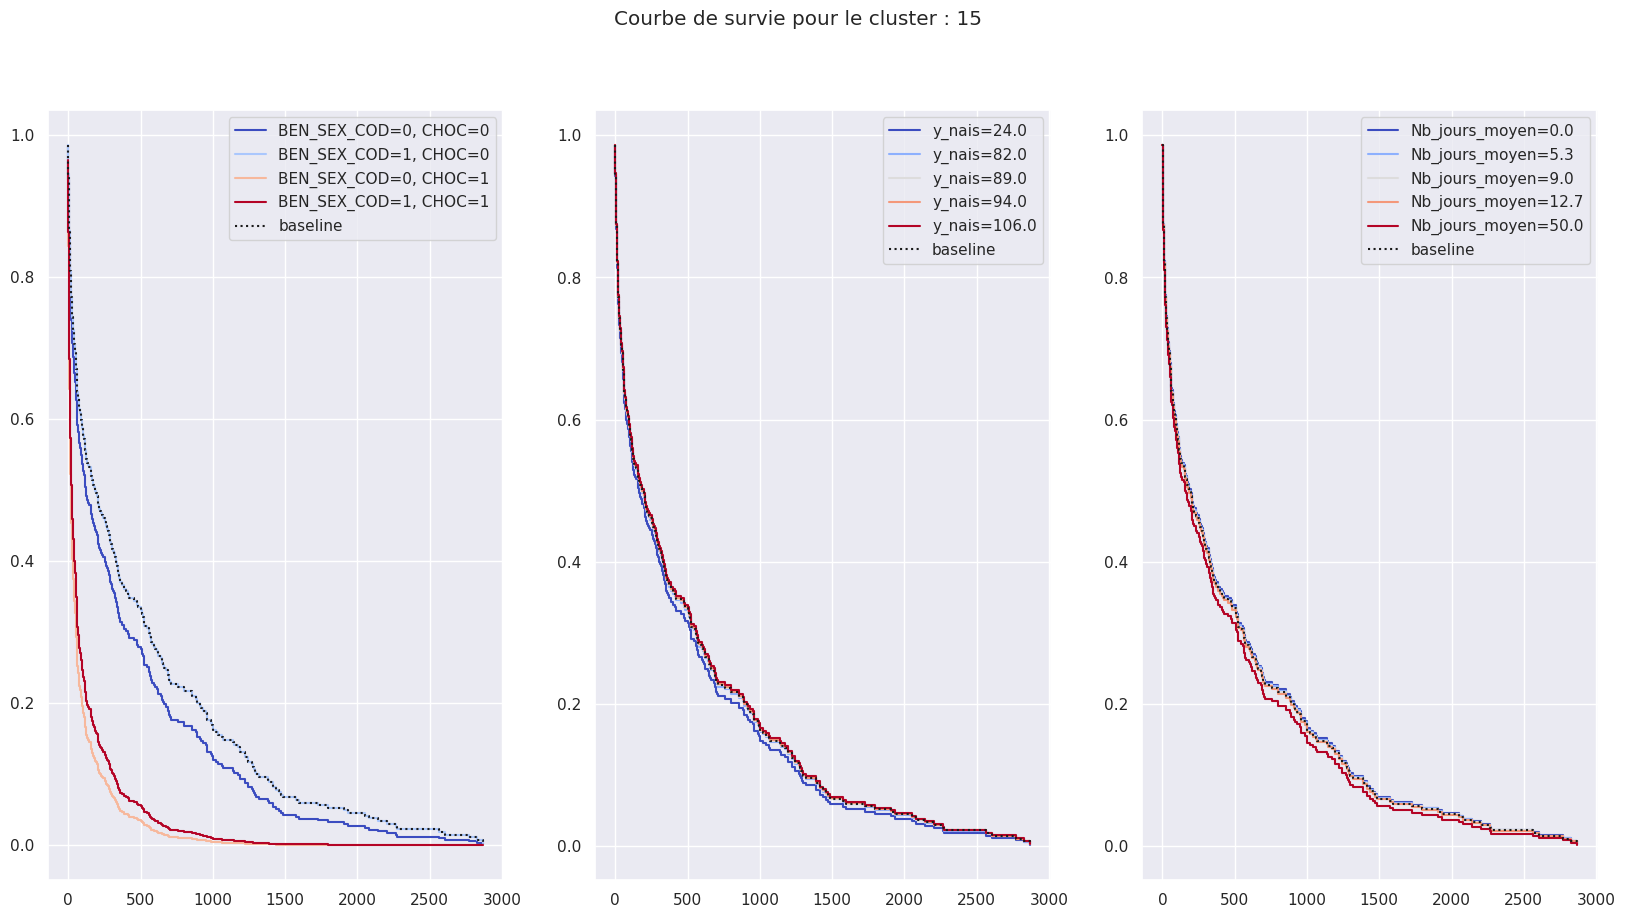

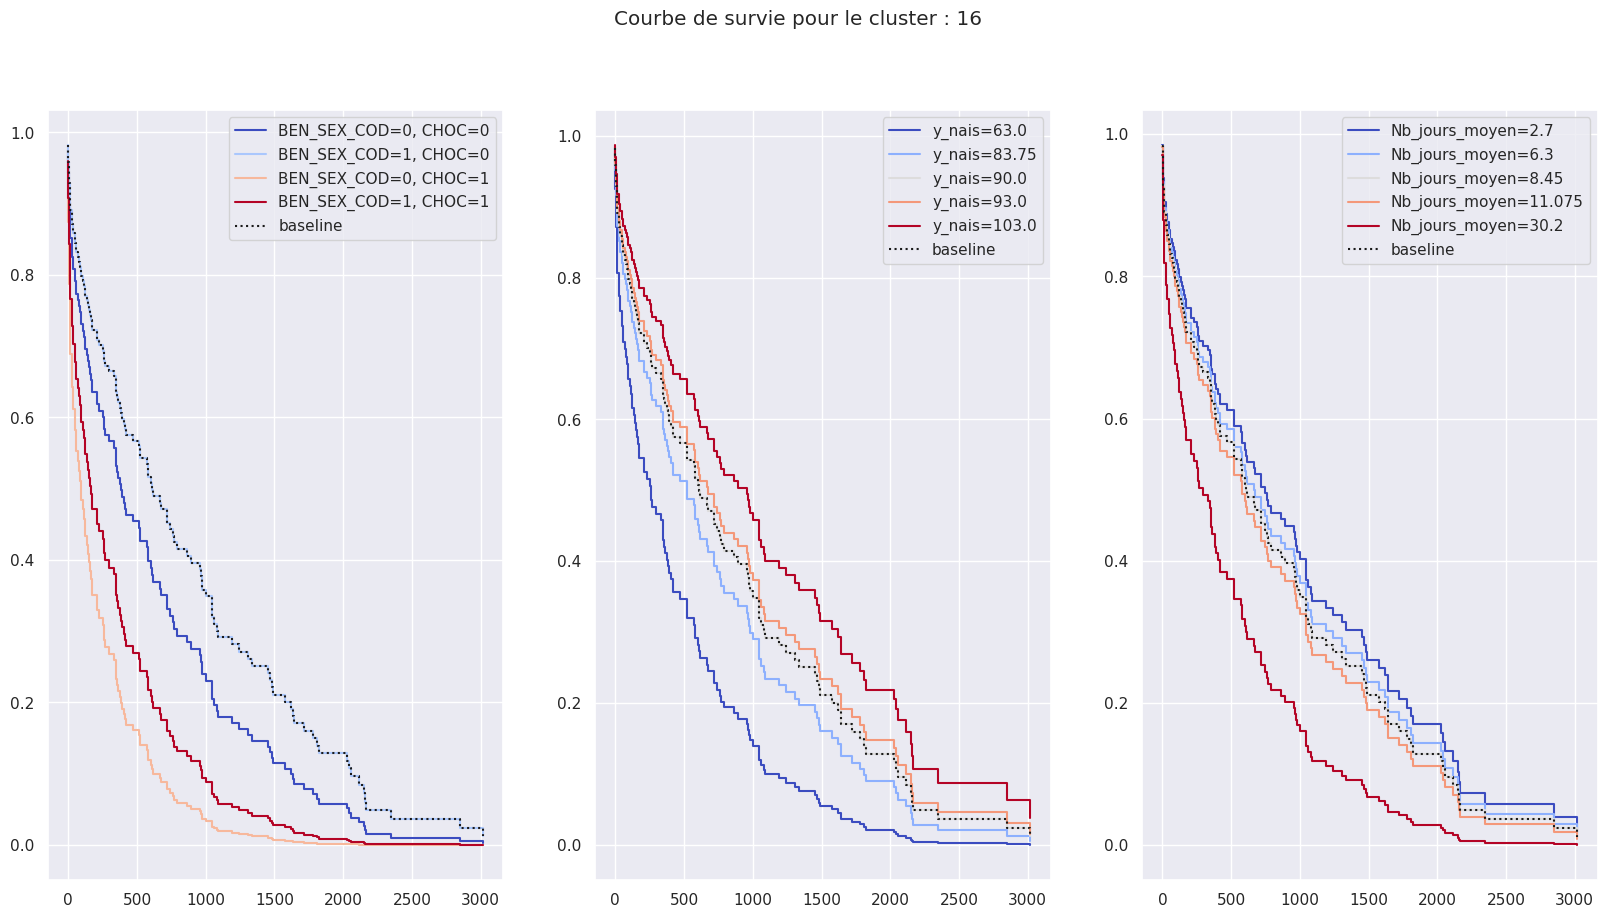

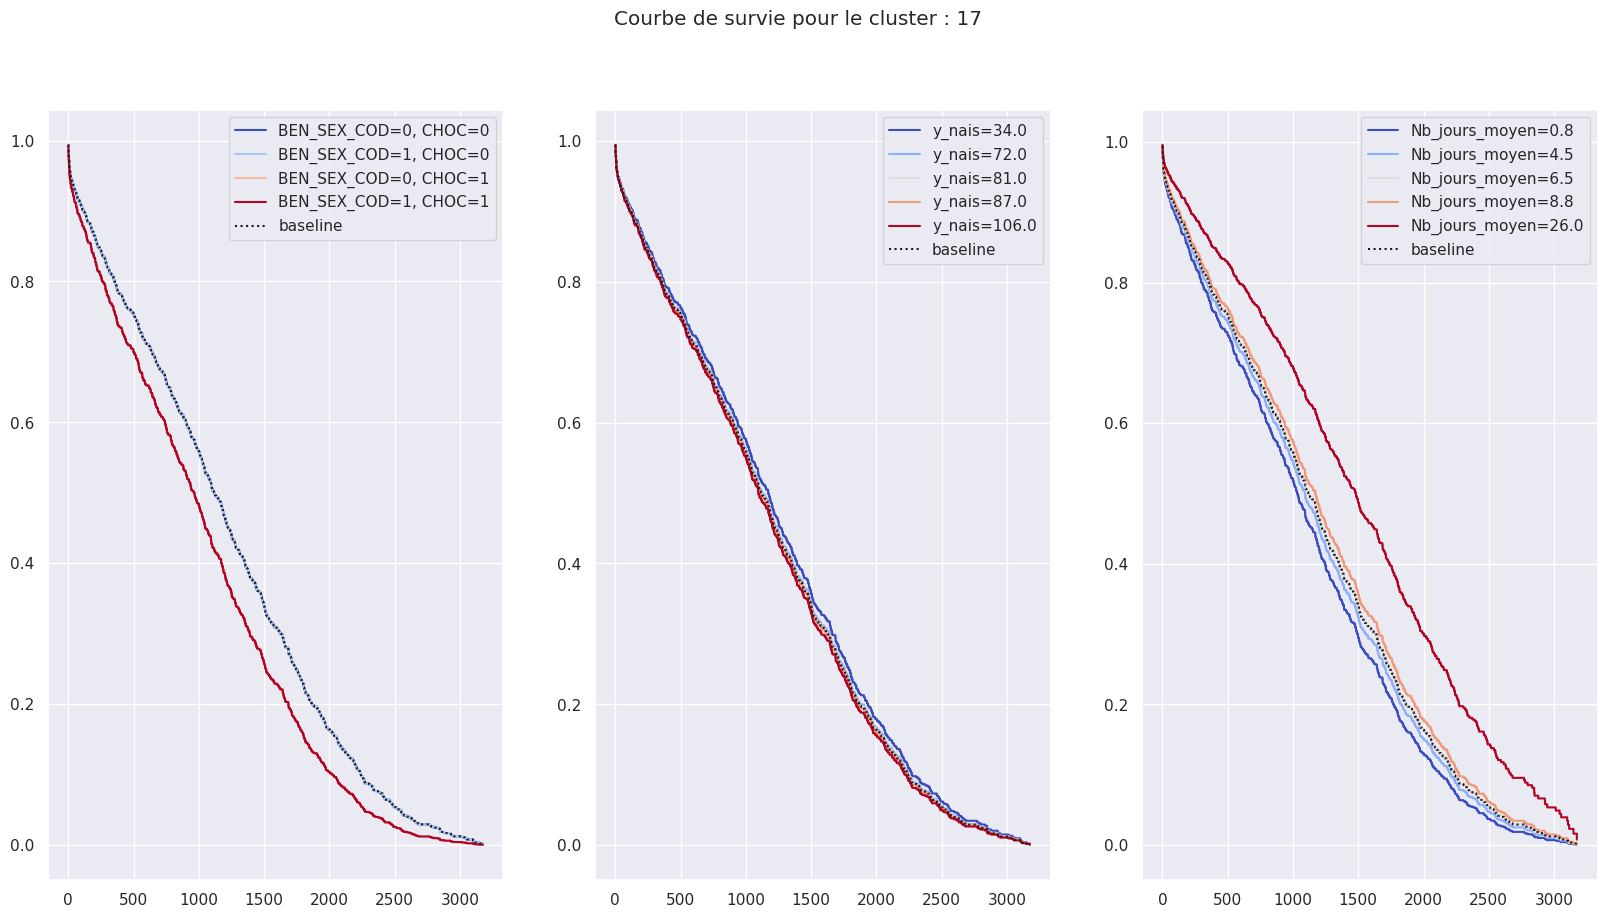

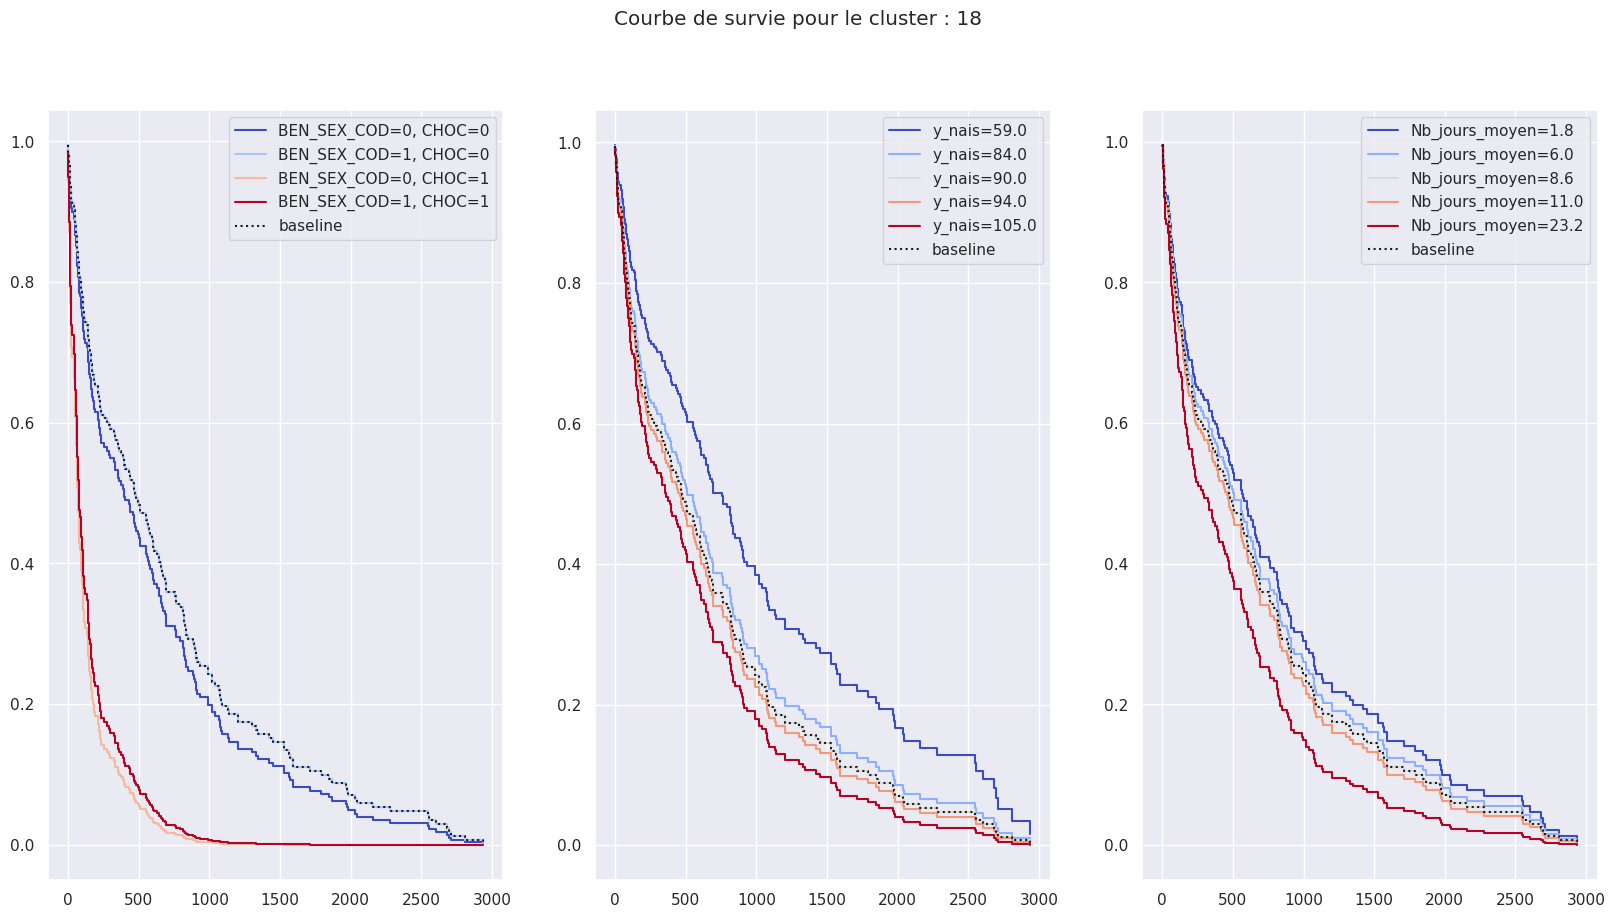

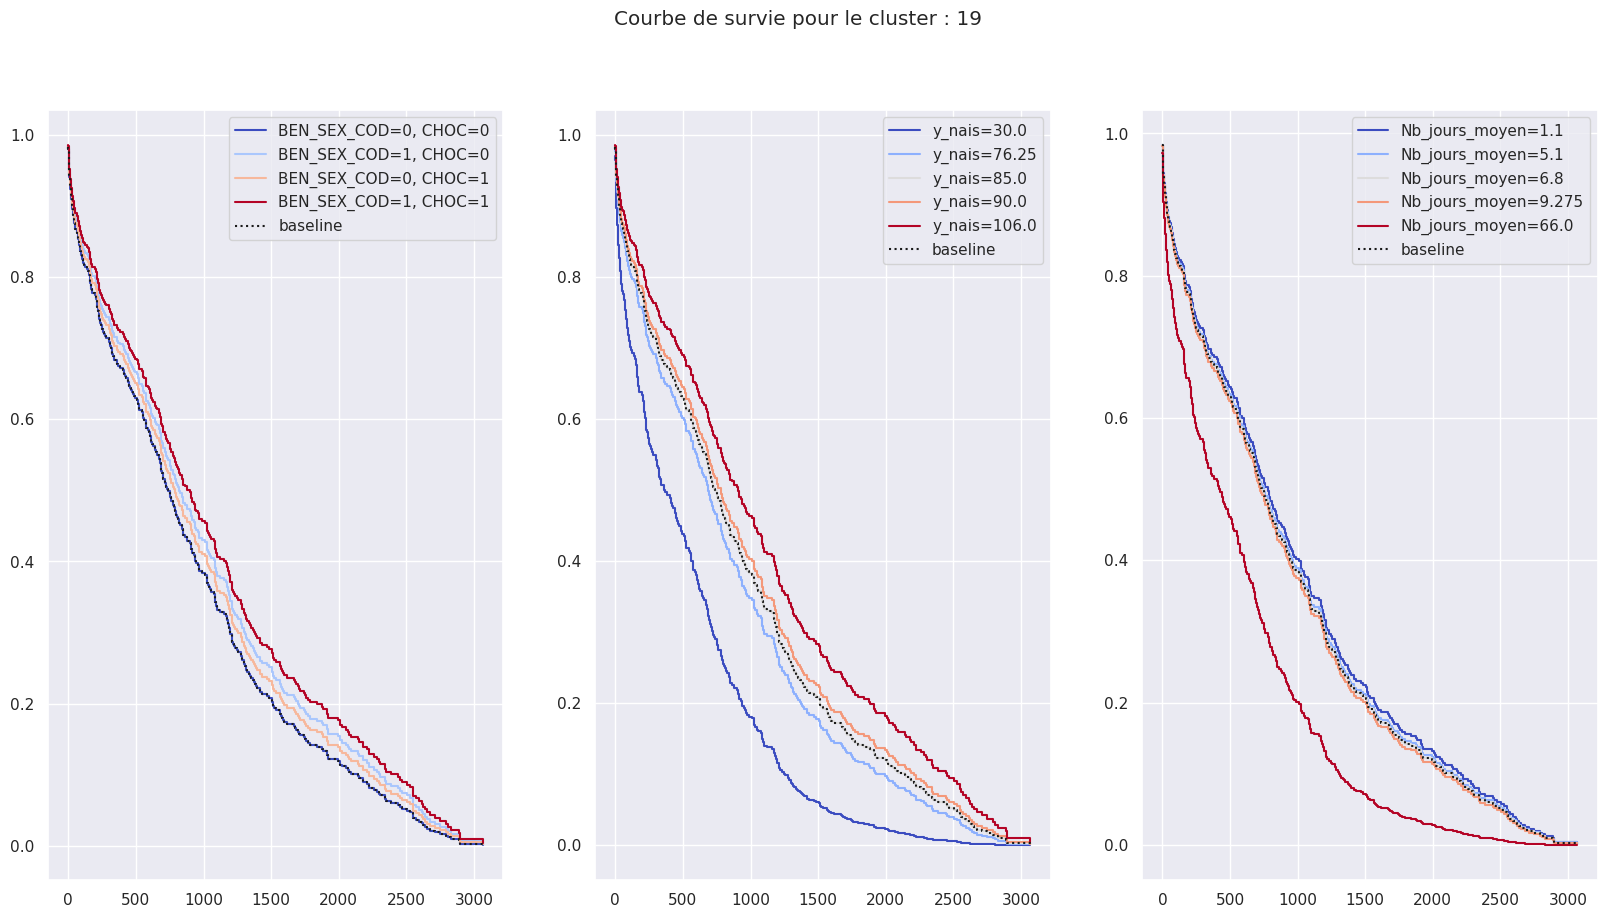

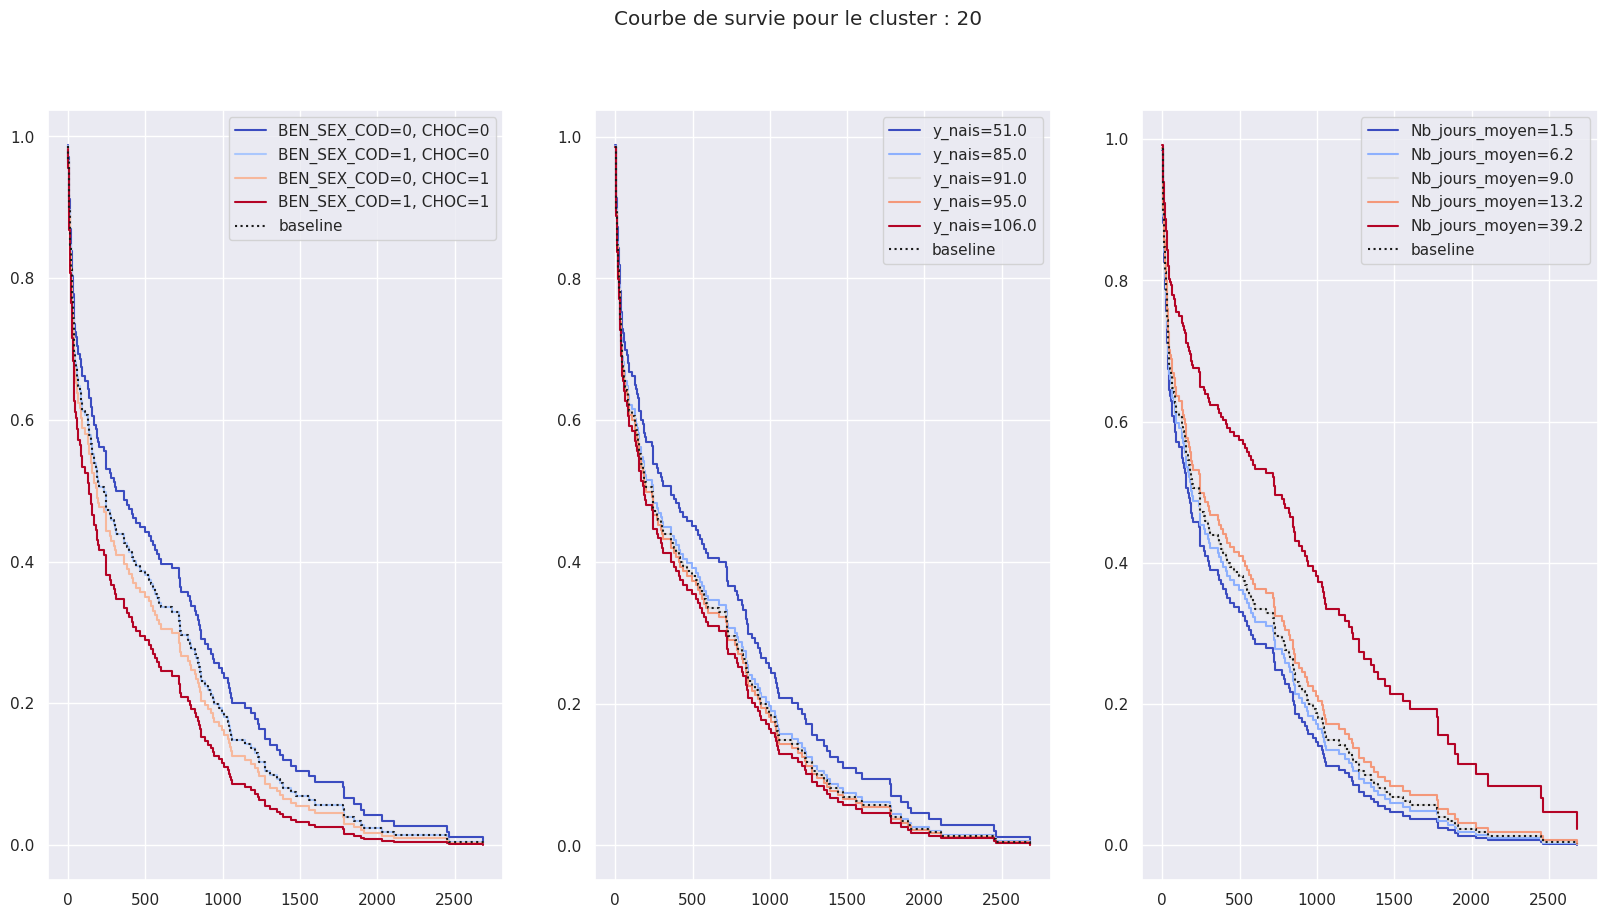

In [1365]:

Bool=False
#A enlever pour obtenir les sorties et les plots
#On définit nos variables
Variables=['y_nais','BEN_SEX_COD','CHOC','Nb_jours_moyen']
Variables_sans_CHOC=['y_nais','BEN_SEX_COD','Nb_jours_moyen']
#P_valeur en dataframe : on extrait et on rename
P_Value=cph.summary.rename(columns={"p": "p_valeur_cluster_"+ str(1)})['p_valeur_cluster_1']
#AIC en liste
Partial_AIC=[]
#Interval de confiance en datafame on extrait et on rename au bon format
df1=cph.summary[['coef lower 95%', 'coef upper 95%']]
Liste_interval=df1.copy()
for i in range (len(df1['coef lower 95%'])):
    Liste_interval.iloc[i]="[" + str(np.around(df1['coef lower 95%'][i],decimals=2)) + " ," + str(np.around(df1['coef upper 95%'][i], decimals=2)) + "]"
Liste_interval=Liste_interval.drop(['coef upper 95%'], axis=1).rename(columns={"coef lower 95%": "Interval de confiance du coefficient cluster 1"})

#P_valeur Ljung-Box on extrait et on rename
Liste_ljung_box=cph.summary.rename(columns={"p": "P-valeur Ljung-Box cluster 1"})['P-valeur Ljung-Box cluster 1']
#On calcule pour chaque co-variable
for variable in Variables:
    scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train_cluster, kind='scaled_schoenfeld')
    result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[5], boxpierce=True, model_df=0, period=None, return_df=None)
    Liste_ljung_box.loc[variable]=np.around(result[1][0], decimals=2)

#Concordance_index
Liste_concordance_index=[]

#Test des hasards proportionnels 
#Rank
results_rank = proportional_hazard_test(cph, data_train_cluster, time_transform='rank')
d = {'p_valeur': results_rank.p_value, "name" : Variables}
df = pd.DataFrame(data=d)
df=df.set_index('name')
Rank=pd.concat([results_rank.test_statistic,df], axis=1)
Rank=Rank.rename(columns={"se": "Statistique du test des hasards proportionnels  (rank) cluster 1"})
Rank=Rank.rename(columns={"p_valeur": "p_valeur cluster 1"})

#km
results_km = proportional_hazard_test(cph, data_train_cluster, time_transform='km')
d = {'p_valeur': results_km.p_value, "name" : Variables}
df = pd.DataFrame(data=d)
df=df.set_index('name')
KM=pd.concat([results_km.test_statistic,df], axis=1)
KM=KM.rename(columns={"se": "Statistique du test des hasards proportionnels  (km) cluster 1"})
KM=KM.rename(columns={"p_valeur": "p_valeur cluster 1"})

#Pour chaque cluster
for i in range (1,Nb_cluster+1):
    Bool=False
    #On extrait le dataframe du cluster en question
    data_train_cluster= extract_cluster_i(i,data_train, Nb_cluster)
    
    if data_train_cluster['CHOC'].nunique()==1:
        data_train_cluster=data_train_cluster.drop(['CHOC'], axis=1)
        Bool=True
    
    
    #On initialise le modèle de Cox
    cph = CoxPHFitter()
    cph.fit(data_train_cluster, duration_col='Nb_survie', event_col='Mort')
    
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
    
    if Bool:
        var=Variables_sans_CHOC
        #Courbe de survie:
        cph.plot_partial_effects_on_outcome(covariates=['BEN_SEX_COD'], values=[0,1], cmap='coolwarm', ax=ax1)
        fig.suptitle("Courbe de survie pour le cluster : " + str(i))
    else:
        var=Variables
        #Courbe de survie:
        cph.plot_partial_effects_on_outcome(covariates=['BEN_SEX_COD','CHOC'], values=[(0,0),(1,0),(0,1),(1,1)], cmap='coolwarm', ax=ax1)
        fig.suptitle("Courbe de survie pour le cluster : " + str(i))

    #Courbe de survie:
    Liste_quantile=[0,.25, .5, .75,1]
    Age=data_train_cluster['y_nais'].quantile(Liste_quantile)
    Nb_jours=data_train_cluster['Nb_jours_moyen'].quantile([0,.25, .5, .75,1])
    cph.plot_partial_effects_on_outcome(covariates=['y_nais'], values=Age, cmap='coolwarm', ax=ax2)

    #Courbe de survie:
    Liste_quantile=[0,.25, .5, .75,1]
    Nb_jours=data_train_cluster['Nb_jours_moyen'].quantile([0,.25, .5, .75,1])
    cph.plot_partial_effects_on_outcome(covariates=['Nb_jours_moyen'], values=Nb_jours, cmap='coolwarm', ax=ax3)
  
    
    
    #On merge à partir du deuxième cluster
    if i>=2:
        #P-valeur
        P_Value=pd.concat([P_Value,cph.summary.rename(columns={"p": "p_valeur_cluster_"+ str(i)})['p_valeur_cluster_' + str(i)]],axis=1)
        
        #Interval de confiance
        df1=cph.summary[['coef lower 95%', 'coef upper 95%']]
        Interval=df1.copy()
        for j in range (len(df1['coef lower 95%'])):
            Interval.iloc[j]="[" + str(np.around(df1['coef lower 95%'][j],decimals=2)) + " ," + str(np.around(df1['coef upper 95%'][j], decimals=2)) + "]"
        Interval=Interval.drop(['coef upper 95%'], axis=1)
        Interval=Interval.rename(columns={"coef lower 95%": "Interval de confiance du coefficient cluster" + str(i)})
        Liste_interval=pd.concat([Liste_interval, Interval], axis=1)
    
    #AIC
    Partial_AIC.append(int(cph.AIC_partial_))
    #Concordance Index
    Liste_concordance_index.append(np.around(cph.concordance_index_,decimals=3))
    
    #Ljung-Box
    #Calcul des résidus de Schoenfeld
    scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train_cluster, kind='scaled_schoenfeld')
    #Pour chaque co-variable:
    for variable in var:
        #Run the Ljung-Box test to test for auto-correlation in residuals up to lag 40
        result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[5], boxpierce=True, model_df=0, period=None, return_df=None)
        #On crée un dataframe que l'on va merge au dataframe global
        if i>=2:
            Ljung_box=cph.summary.rename(columns={"p": "P-valeur Ljung-Box cluster " + str(i)})['P-valeur Ljung-Box cluster ' + str(i)]
            Ljung_box.loc[variable]=np.around(result[1][0], decimals=2)
    #On merge Ljung-Box global
    if i>=2:
        Liste_ljung_box=pd.concat([Liste_ljung_box,Ljung_box], axis=1)
        
    #Test des hasards proportionnels
    if i>=2:
        #Rank
        results_rank = proportional_hazard_test(cph, data_train_cluster, time_transform='rank')
        d = {'p_valeur': results_rank.p_value, "name" : var}
        df = pd.DataFrame(data=d)
        df=df.set_index('name')
        rank=pd.concat([results_rank.test_statistic,df], axis=1)
        rank=rank.rename(columns={"se": "Statistique du test des hasards proportionnels  (rank) cluster " + str(i)})
        rank=rank.rename(columns={"p_valeur": "p_valeur cluster " + str(i)})
        #On merge au dataframe global
        Rank=pd.concat([Rank,rank], axis=1)
        
        #km
        results_km = proportional_hazard_test(cph, data_train_cluster, time_transform='km')
        d = {'p_valeur': results_km.p_value, "name" : var}
        df = pd.DataFrame(data=d)
        df=df.set_index('name')
        km=pd.concat([results_km.test_statistic,df], axis=1)
        km=km.rename(columns={"se": "Statistique du test des hasards proportionnels  (km) cluster " + str(i)})
        km=km.rename(columns={"p_valeur": "p_valeur cluster " + str(i)})
        #On merge au dataframe global
        KM=pd.concat([KM,km], axis=1)

### P_value

In [1366]:
P_Value

p_valeur_cluster_1  p_valeur_cluster_2  p_valeur_cluster_3  \
covariate                                                                    
y_nais                4.011115e-01            0.924428            0.791803   
BEN_SEX_COD           1.122274e-02            0.846148            0.102481   
CHOC                  6.512802e-11            0.625133            0.170445   
Nb_jours_moyen        7.423998e-06            0.740959            0.380489   

                p_valeur_cluster_4  p_valeur_cluster_5  p_valeur_cluster_6  \
covariate                                                                    
y_nais                    0.000011            0.279492        3.524675e-01   
BEN_SEX_COD               0.690023            0.271363        9.103483e-01   
CHOC                      0.979986            0.167013        5.452758e-09   
Nb_jours_moyen            0.013026            0.144300        2.581223e-01   

                p_valeur_cluster_7  p_valeur_cluster_8  p_valeur_cluster_9  \
covariate                                                                    
y_nais                    0.476771            0.320935            0.974310   
BEN_SEX_COD               0.919268            0.477165            0.562954   
CHOC                      0.041102            0.838395            0.138537   
Nb_jours_moyen            0.159859            0.872496            0.890698   

                p_valeur_cluster_10  p_valeur_cluster_11  p_valeur_cluster_12  \
covariate                                                                       
y_nais                     0.454034             0.444517             0.476343   
BEN_SEX_COD                0.865750             0.966881             0.842947   
CHOC                       0.052253             0.051439             0.987975   
Nb_jours_moyen             0.695922             0.318765             0.682315   

                p_valeur_cluster_13  p_valeur_cluster_14  p_valeur_cluster_15  \
covariate                                                                       
y_nais                     0.195487         6.845926e-01             0.895370   
BEN_SEX_COD                0.062928         4.640705e-01             0.193396   
CHOC                            NaN         1.582719e-07             0.002322   
Nb_jours_moyen             0.591278         5.261139e-01             0.874143   

                p_valeur_cluster_16  p_valeur_cluster_17  p_valeur_cluster_18  \
covariate                                                                       
y_nais                     0.074794             0.762193             0.225988   
BEN_SEX_COD                0.091598             0.997379             0.434669   
CHOC                       0.035123             0.142174             0.037476   
Nb_jours_moyen             0.215706             0.101482             0.338233   

                p_valeur_cluster_19  p_valeur_cluster_20  
covariate                                                 
y_nais                     0.061530             0.631161  
BEN_SEX_COD                0.259180             0.382691  
CHOC                       0.740179             0.630468  
Nb_jours_moyen             0.453090             0.160860

In [1367]:
P_value_seuil= (P_Value[P_Value<=0.05] == P_Value)*1 + (P_Value[P_Value>0.05] == P_Value)*0 + (pd.isna(P_Value))*-1

In [1368]:
P_value_seuil

p_valeur_cluster_1  p_valeur_cluster_2  p_valeur_cluster_3  \
covariate                                                                    
y_nais                           0                   0                   0   
BEN_SEX_COD                      1                   0                   0   
CHOC                             1                   0                   0   
Nb_jours_moyen                   1                   0                   0   

                p_valeur_cluster_4  p_valeur_cluster_5  p_valeur_cluster_6  \
covariate                                                                    
y_nais                           1                   0                   0   
BEN_SEX_COD                      0                   0                   0   
CHOC                             0                   0                   1   
Nb_jours_moyen                   1                   0                   0   

                p_valeur_cluster_7  p_valeur_cluster_8  p_valeur_cluster_9  \
covariate                                                                    
y_nais                           0                   0                   0   
BEN_SEX_COD                      0                   0                   0   
CHOC                             1                   0                   0   
Nb_jours_moyen                   0                   0                   0   

                p_valeur_cluster_10  p_valeur_cluster_11  p_valeur_cluster_12  \
covariate                                                                       
y_nais                            0                    0                    0   
BEN_SEX_COD                       0                    0                    0   
CHOC                              0                    0                    0   
Nb_jours_moyen                    0                    0                    0   

                p_valeur_cluster_13  p_valeur_cluster_14  p_valeur_cluster_15  \
covariate                                                                       
y_nais                            0                    0                    0   
BEN_SEX_COD                       0                    0                    0   
CHOC                             -1                    1                    1   
Nb_jours_moyen                    0                    0                    0   

                p_valeur_cluster_16  p_valeur_cluster_17  p_valeur_cluster_18  \
covariate                                                                       
y_nais                            0                    0                    0   
BEN_SEX_COD                       0                    0                    0   
CHOC                              1                    0                    1   
Nb_jours_moyen                    0                    0                    0   

                p_valeur_cluster_19  p_valeur_cluster_20  
covariate                                                 
y_nais                            0                    0  
BEN_SEX_COD                       0                    0  
CHOC                              0                    0  
Nb_jours_moyen                    0                    0

<Axes: ylabel='covariate'>

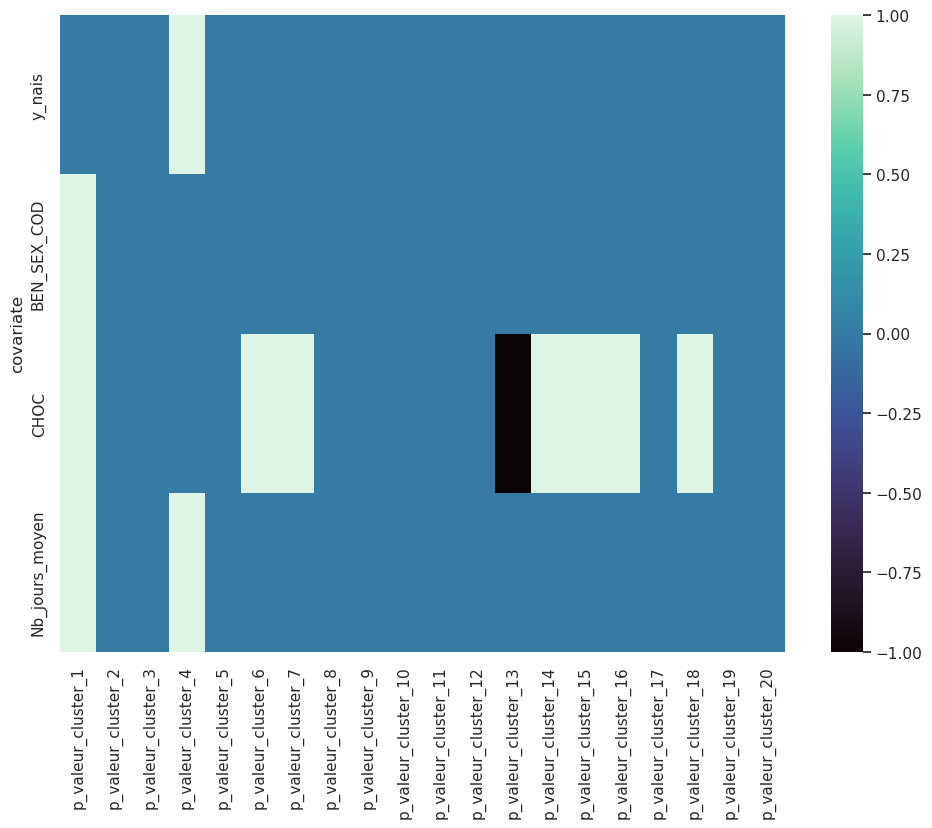

In [1369]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("darkgrid")
sns.heatmap(P_value_seuil, cmap="mako")

### AIC

In [1370]:
for counter, AIC in enumerate(Partial_AIC):
    print( "Cluster_" + str(counter+1 ) + "  Partial AIC : " + str(Partial_AIC[counter]))

Cluster_1  Partial AIC : 6824
Cluster_2  Partial AIC : 856
Cluster_3  Partial AIC : 3027
Cluster_4  Partial AIC : 3453
Cluster_5  Partial AIC : 585
Cluster_6  Partial AIC : 2150
Cluster_7  Partial AIC : 4026
Cluster_8  Partial AIC : 642
Cluster_9  Partial AIC : 2384
Cluster_10  Partial AIC : 1183
Cluster_11  Partial AIC : 3387
Cluster_12  Partial AIC : 799
Cluster_13  Partial AIC : 442
Cluster_14  Partial AIC : 2861
Cluster_15  Partial AIC : 3080
Cluster_16  Partial AIC : 909
Cluster_17  Partial AIC : 7378
Cluster_18  Partial AIC : 1613
Cluster_19  Partial AIC : 3502
Cluster_20  Partial AIC : 1245


### Concordance Index

In [1371]:
for counter, AIC in enumerate(Liste_concordance_index):
    print( "Cluster_" + str(counter +1) + "  Concordance Index : " + str(Liste_concordance_index[counter]))
print('\n')
print("Moyenne du Concordance Index : " + str(np.mean(Liste_concordance_index)))

Cluster_1  Concordance Index : 0.612
Cluster_2  Concordance Index : 0.519
Cluster_3  Concordance Index : 0.572
Cluster_4  Concordance Index : 0.574
Cluster_5  Concordance Index : 0.629
Cluster_6  Concordance Index : 0.584
Cluster_7  Concordance Index : 0.529
Cluster_8  Concordance Index : 0.545
Cluster_9  Concordance Index : 0.531
Cluster_10  Concordance Index : 0.55
Cluster_11  Concordance Index : 0.527
Cluster_12  Concordance Index : 0.546
Cluster_13  Concordance Index : 0.589
Cluster_14  Concordance Index : 0.585
Cluster_15  Concordance Index : 0.521
Cluster_16  Concordance Index : 0.621
Cluster_17  Concordance Index : 0.535
Cluster_18  Concordance Index : 0.506
Cluster_19  Concordance Index : 0.535
Cluster_20  Concordance Index : 0.527


Moyenne du Concordance Index : 0.55685


### Intervalle de confiance

In [1372]:
Liste_interval

Interval de confiance du coefficient cluster 1  \
covariate                                                       
y_nais                                           [-0.0 ,0.01]   
BEN_SEX_COD                                    [-0.39 ,-0.05]   
CHOC                                             [0.84 ,1.55]   
Nb_jours_moyen                                 [-0.03 ,-0.01]   

               Interval de confiance du coefficient cluster2  \
covariate                                                      
y_nais                                         [-0.02 ,0.02]   
BEN_SEX_COD                                    [-0.45 ,0.37]   
CHOC                                           [-1.55 ,0.93]   
Nb_jours_moyen                                 [-0.05 ,0.04]   

               Interval de confiance du coefficient cluster3  \
covariate                                                      
y_nais                                         [-0.01 ,0.01]   
BEN_SEX_COD                                    [-0.43 ,0.04]   
CHOC                                           [-0.15 ,0.82]   
Nb_jours_moyen                                 [-0.03 ,0.01]   

               Interval de confiance du coefficient cluster4  \
covariate                                                      
y_nais                                        [-0.04 ,-0.01]   
BEN_SEX_COD                                    [-0.18 ,0.27]   
CHOC                                            [-0.8 ,0.82]   
Nb_jours_moyen                                [-0.05 ,-0.01]   

               Interval de confiance du coefficient cluster5  \
covariate                                                      
y_nais                                         [-0.01 ,0.03]   
BEN_SEX_COD                                     [-0.72 ,0.2]   
CHOC                                            [-0.61 ,3.5]   
Nb_jours_moyen                                 [-0.05 ,0.01]   

               Interval de confiance du coefficient cluster6  \
covariate                                                      
y_nais                                         [-0.02 ,0.01]   
BEN_SEX_COD                                    [-0.31 ,0.28]   
CHOC                                            [1.05 ,2.11]   
Nb_jours_moyen                                 [-0.04 ,0.01]   

               Interval de confiance du coefficient cluster7  \
covariate                                                      
y_nais                                         [-0.01 ,0.01]   
BEN_SEX_COD                                    [-0.22 ,0.19]   
CHOC                                            [0.02 ,1.01]   
Nb_jours_moyen                                 [-0.01 ,0.04]   

               Interval de confiance du coefficient cluster8  \
covariate                                                      
y_nais                                         [-0.01 ,0.03]   
BEN_SEX_COD                                    [-0.27 ,0.58]   
CHOC                                           [-0.95 ,1.17]   
Nb_jours_moyen                                 [-0.05 ,0.05]   

               Interval de confiance du coefficient cluster9  \
covariate                                                      
y_nais                                         [-0.01 ,0.01]   
BEN_SEX_COD                                    [-0.33 ,0.18]   
CHOC                                           [-0.16 ,1.18]   
Nb_jours_moyen                                 [-0.04 ,0.03]   

               Interval de confiance du coefficient cluster10  \
covariate                                                       
y_nais                                          [-0.02 ,0.01]   
BEN_SEX_COD                                     [-0.31 ,0.36]   
CHOC                                            [-0.01 ,1.28]   
Nb_jours_moyen                                  [-0.03 ,0.05]   

               Interval de confiance du coefficient cluster11  \
covariate                                                       
y_nais                 

### Ljung-Box

In [1373]:
Liste_ljung_box

P-valeur Ljung-Box cluster 1  P-valeur Ljung-Box cluster 2  \
covariate                                                                    
y_nais                                  0.25                      0.924428   
BEN_SEX_COD                             0.01                      0.846148   
CHOC                                    0.69                      0.625133   
Nb_jours_moyen                          0.00                      0.360000   

                P-valeur Ljung-Box cluster 3  P-valeur Ljung-Box cluster 4  \
covariate                                                                    
y_nais                              0.791803                      0.000011   
BEN_SEX_COD                         0.102481                      0.690023   
CHOC                                0.170445                      0.979986   
Nb_jours_moyen                      0.060000                      0.150000   

                P-valeur Ljung-Box cluster 5  P-valeur Ljung-Box cluster 6  \
covariate                                                                    
y_nais                              0.279492                  3.524675e-01   
BEN_SEX_COD                         0.271363                  9.103483e-01   
CHOC                                0.167013                  5.452758e-09   
Nb_jours_moyen                      0.000000                  2.500000e-01   

                P-valeur Ljung-Box cluster 7  P-valeur Ljung-Box cluster 8  \
covariate                                                                    
y_nais                              0.476771                      0.320935   
BEN_SEX_COD                         0.919268                      0.477165   
CHOC                                0.041102                      0.838395   
Nb_jours_moyen                      0.250000                      0.000000   

                P-valeur Ljung-Box cluster 9  P-valeur Ljung-Box cluster 10  \
covariate                                                                     
y_nais                              0.974310                       0.454034   
BEN_SEX_COD                         0.562954                       0.865750   
CHOC                                0.138537                       0.052253   
Nb_jours_moyen                      0.650000                       0.160000   

                P-valeur Ljung-Box cluster 11  P-valeur Ljung-Box cluster 12  \
covariate                                                                      
y_nais                               0.444517                       0.476343   
BEN_SEX_COD                          0.966881                       0.842947   
CHOC                                 0.051439                       0.987975   
Nb_jours_moyen                       0.540000                       0.580000   

                P-valeur Ljung-Box cluster 13  P-valeur Ljung-Box cluster 14  \
covariate                                                                      
y_nais                               0.195487                   6.845926e-01   
BEN_SEX_COD                          0.062928                   4.640705e-01   
CHOC                                      NaN                   1.582719e-07   
Nb_jours_moyen                       0.510000                   3.300000e-01   

                P-valeur Ljung-Box cluster 15  P-valeur Ljung-Box cluster 16  \
covariate                                                                      
y_nais                               0.895370                       0.074794   
BEN_SEX_COD                          0.193396                       0.091598   
CHOC                                 0.002322                       0.035123   
Nb_jours_moyen                       0.470000                       0.480000   

                P-valeur Ljung-Box cluster 17  P-valeur Ljung-Box cluster 18  \
covariate                                                                      
y_nais                               0.762193                 

In [1374]:
Liste_ljung_box_seuil=(Liste_ljung_box[Liste_ljung_box>=0.05] == Liste_ljung_box)*1 + (Liste_ljung_box[Liste_ljung_box<0.05] == Liste_ljung_box)*0 + (pd.isna(Liste_ljung_box))*-1

In [1375]:
Liste_ljung_box_seuil

P-valeur Ljung-Box cluster 1  P-valeur Ljung-Box cluster 2  \
covariate                                                                    
y_nais                                     1                             1   
BEN_SEX_COD                                0                             1   
CHOC                                       1                             1   
Nb_jours_moyen                             0                             1   

                P-valeur Ljung-Box cluster 3  P-valeur Ljung-Box cluster 4  \
covariate                                                                    
y_nais                                     1                             0   
BEN_SEX_COD                                1                             1   
CHOC                                       1                             1   
Nb_jours_moyen                             1                             1   

                P-valeur Ljung-Box cluster 5  P-valeur Ljung-Box cluster 6  \
covariate                                                                    
y_nais                                     1                             1   
BEN_SEX_COD                                1                             1   
CHOC                                       1                             0   
Nb_jours_moyen                             0                             1   

                P-valeur Ljung-Box cluster 7  P-valeur Ljung-Box cluster 8  \
covariate                                                                    
y_nais                                     1                             1   
BEN_SEX_COD                                1                             1   
CHOC                                       0                             1   
Nb_jours_moyen                             1                             0   

                P-valeur Ljung-Box cluster 9  P-valeur Ljung-Box cluster 10  \
covariate                                                                     
y_nais                                     1                              1   
BEN_SEX_COD                                1                              1   
CHOC                                       1                              1   
Nb_jours_moyen                             1                              1   

                P-valeur Ljung-Box cluster 11  P-valeur Ljung-Box cluster 12  \
covariate                                                                      
y_nais                                      1                              1   
BEN_SEX_COD                                 1                              1   
CHOC                                        1                              1   
Nb_jours_moyen                              1                              1   

                P-valeur Ljung-Box cluster 13  P-valeur Ljung-Box cluster 14  \
covariate                                                                      
y_nais                                      1                              1   
BEN_SEX_COD                                 1                              1   
CHOC                                       -1                              0   
Nb_jours_moyen                              1                              1   

                P-valeur Ljung-Box cluster 15  P-valeur Ljung-Box cluster 16  \
covariate                                                                      
y_nais                                      1                              1   
BEN_SEX_COD                                 1                              1   
CHOC                                        0                              0   
Nb_jours_moyen                              1                              1   

                P-valeur Ljung-Box cluster 17  P-valeur Ljung-Box cluster 18  \
covariate                                                                      
y_nais                                      1                 

<Axes: ylabel='covariate'>

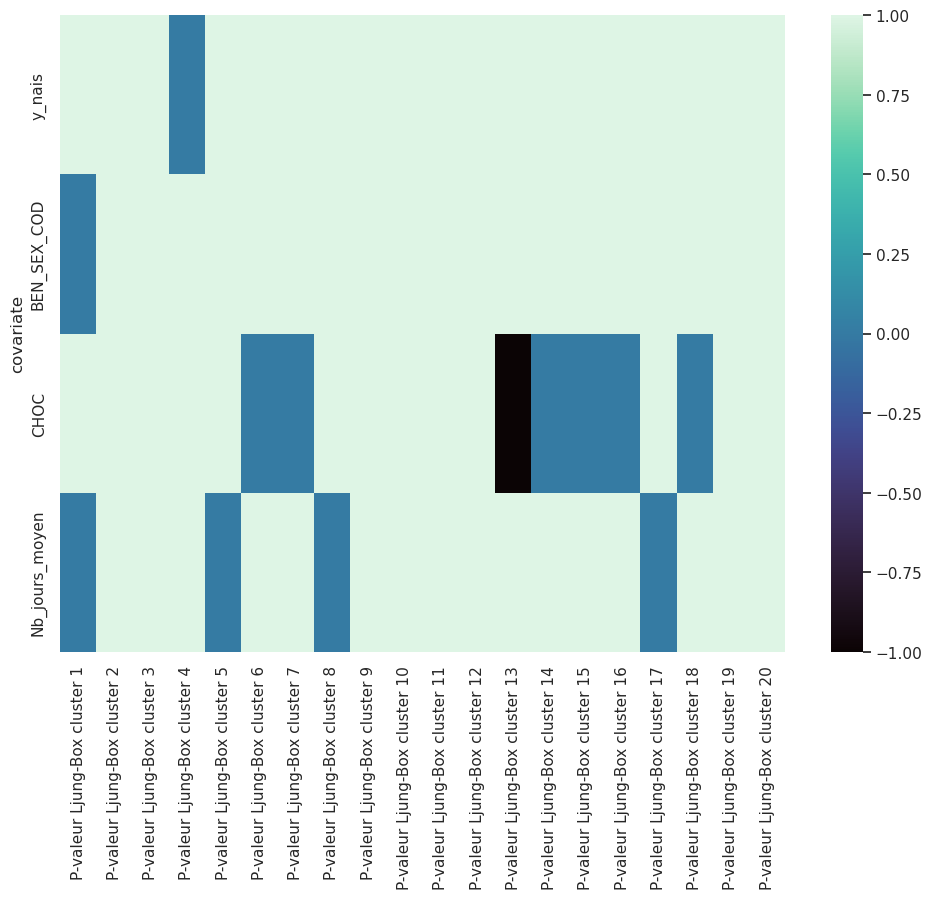

In [1376]:
sns.heatmap(Liste_ljung_box_seuil, cmap="mako")

### Test des hasards proportionnels

In [1377]:
Rank

Statistique du test des hasards proportionnels  (rank) cluster 1  \
y_nais                                                   8.256747                  
BEN_SEX_COD                                              1.916509                  
CHOC                                                     0.078670                  
Nb_jours_moyen                                         107.438648                  

                p_valeur cluster 1  \
y_nais                4.060081e-03   
BEN_SEX_COD           1.662421e-01   
CHOC                  7.791085e-01   
Nb_jours_moyen        3.567808e-25   

                Statistique du test des hasards proportionnels  (rank) cluster 2  \
y_nais                                                   0.166438                  
BEN_SEX_COD                                              0.001331                  
CHOC                                                     0.020738                  
Nb_jours_moyen                                           0.023100                  

                p_valeur cluster 2  \
y_nais                    0.683297   
BEN_SEX_COD               0.970901   
CHOC                      0.885496   
Nb_jours_moyen            0.879198   

                Statistique du test des hasards proportionnels  (rank) cluster 3  \
y_nais                                                   0.130870                  
BEN_SEX_COD                                              2.678848                  
CHOC                                                    12.650975                  
Nb_jours_moyen                                          17.230502                  

                p_valeur cluster 3  \
y_nais                    0.717531   
BEN_SEX_COD               0.101689   
CHOC                      0.000375   
Nb_jours_moyen            0.000033   

                Statistique du test des hasards proportionnels  (rank) cluster 4  \
y_nais                                                   0.357941                  
BEN_SEX_COD                                              0.742867                  
CHOC                                                     0.007153                  
Nb_jours_moyen                                           3.134527                  

                p_valeur cluster 4  \
y_nais                    0.549652   
BEN_SEX_COD               0.388744   
CHOC                      0.932601   
Nb_jours_moyen            0.076651   

                Statistique du test des hasards proportionnels  (rank) cluster 5  \
y_nais                                                   0.593464                  
BEN_SEX_COD                                              2.818536                  
CHOC                                                     1.393489                  
Nb_jours_moyen                                          19.653760                  

                p_valeur cluster 5  ...  \
y_nais                    0.441083  ...   
BEN_SEX_COD               0.093181  ...   
CHOC                      0.237817  ...   
Nb_jours_moyen            0.000009  ...   

                Statistique du test des hasards proportionnels  (rank) cluster 16  \
y_nais                                                   7.299061                   
BEN_SEX_COD                                              0.223104                   
CHOC                                                     0.013597                   
Nb_jours_moyen                                           1.453814                   

                p_valeur cluster 16  \
y_nais                     0.006899   
BEN_SEX_COD                0.636685   
CHOC                       0.907172   
Nb_jours_moyen             0.227917   

                Statistique du test des hasards proportionnels  (rank) cluster 17  \
y_nais                                                   3.738098                   
BEN_SEX_COD                                              0.902604                   
CHOC                                                  

In [1378]:
Rank_seuil=Rank.copy()
Rank_seuil=(Rank[Rank>=0.05] == Rank)*1 + (Rank[Rank<0.05] == Rank)*0 + (pd.isna(Rank))*-1
for i in range (1,Nb_cluster+1):
    Rank_seuil=Rank_seuil.drop(["Statistique du test des hasards proportionnels  (rank) cluster " + str(i)], axis=1)
Rank_seuil

p_valeur cluster 1  p_valeur cluster 2  p_valeur cluster 3  \
y_nais                           0                   1                   1   
BEN_SEX_COD                      1                   1                   1   
CHOC                             1                   1                   0   
Nb_jours_moyen                   0                   1                   0   

                p_valeur cluster 4  p_valeur cluster 5  p_valeur cluster 6  \
y_nais                           1                   1                   0   
BEN_SEX_COD                      1                   1                   1   
CHOC                             1                   1                   1   
Nb_jours_moyen                   1                   0                   1   

                p_valeur cluster 7  p_valeur cluster 8  p_valeur cluster 9  \
y_nais                           1                   1                   1   
BEN_SEX_COD                      1                   1                   1   
CHOC                             1                   1                   0   
Nb_jours_moyen                   0                   1                   1   

                p_valeur cluster 10  p_valeur cluster 11  p_valeur cluster 12  \
y_nais                            1                    1                    1   
BEN_SEX_COD                       1                    1                    1   
CHOC                              1                    0                    1   
Nb_jours_moyen                    1                    1                    0   

                p_valeur cluster 13  p_valeur cluster 14  p_valeur cluster 15  \
y_nais                            1                    0                    0   
BEN_SEX_COD                       1                    1                    1   
CHOC                             -1                    0                    1   
Nb_jours_moyen                    1                    0                    0   

                p_valeur cluster 16  p_valeur cluster 17  p_valeur cluster 18  \
y_nais                            0                    1                    0   
BEN_SEX_COD                       1                    1                    1   
CHOC                              1                    1                    1   
Nb_jours_moyen                    1                    1                    0   

                p_valeur cluster 19  p_valeur cluster 20  
y_nais                            1                    0  
BEN_SEX_COD                       1                    1  
CHOC                              1                    1  
Nb_jours_moyen                    1                    1

<Axes: >

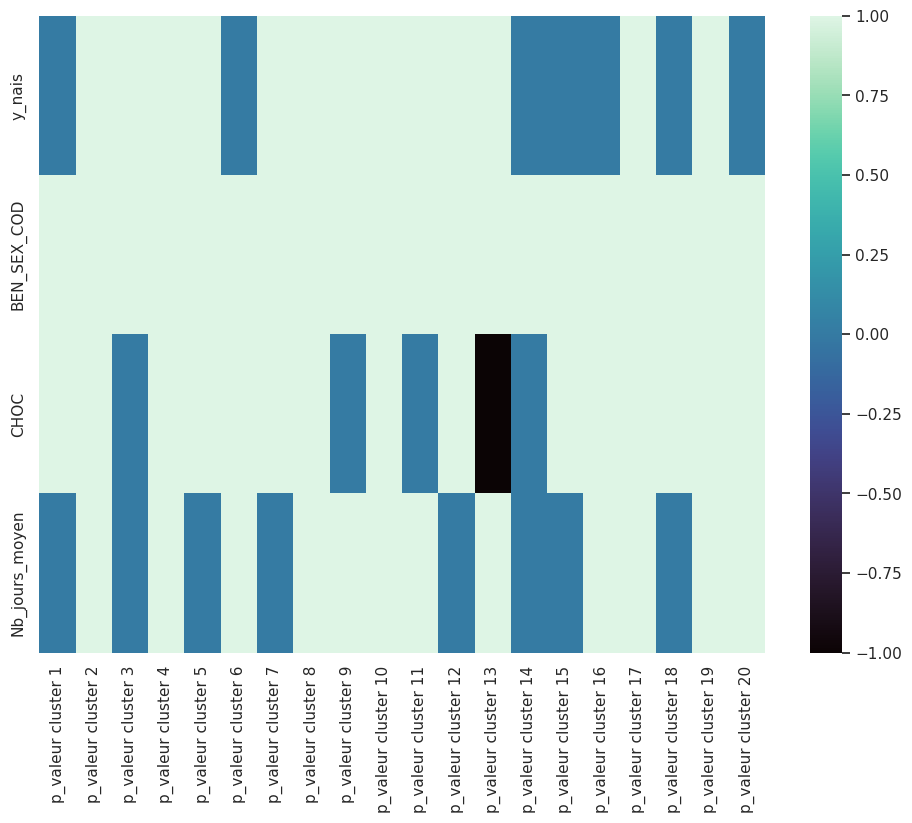

In [1379]:
sns.heatmap(Rank_seuil, cmap="mako")

In [1380]:
KM

Statistique du test des hasards proportionnels  (km) cluster 1  \
y_nais                                                   8.153130                
BEN_SEX_COD                                              1.938330                
CHOC                                                     0.082104                
Nb_jours_moyen                                         105.946445                

                p_valeur cluster 1  \
y_nais                4.298690e-03   
BEN_SEX_COD           1.638500e-01   
CHOC                  7.744659e-01   
Nb_jours_moyen        7.575513e-25   

                Statistique du test des hasards proportionnels  (km) cluster 2  \
y_nais                                                   0.169721                
BEN_SEX_COD                                              0.001426                
CHOC                                                     0.026038                
Nb_jours_moyen                                           0.020022                

                p_valeur cluster 2  \
y_nais                    0.680360   
BEN_SEX_COD               0.969877   
CHOC                      0.871807   
Nb_jours_moyen            0.887475   

                Statistique du test des hasards proportionnels  (km) cluster 3  \
y_nais                                                   0.134129                
BEN_SEX_COD                                              2.700463                
CHOC                                                    12.868731                
Nb_jours_moyen                                          17.065101                

                p_valeur cluster 3  \
y_nais                    0.714189   
BEN_SEX_COD               0.100319   
CHOC                      0.000334   
Nb_jours_moyen            0.000036   

                Statistique du test des hasards proportionnels  (km) cluster 4  \
y_nais                                                   0.370676                
BEN_SEX_COD                                              0.755392                
CHOC                                                     0.005140                
Nb_jours_moyen                                           3.120194                

                p_valeur cluster 4  \
y_nais                    0.542636   
BEN_SEX_COD               0.384774   
CHOC                      0.942843   
Nb_jours_moyen            0.077328   

                Statistique du test des hasards proportionnels  (km) cluster 5  \
y_nais                                                   0.535401                
BEN_SEX_COD                                              2.811598                
CHOC                                                     1.188697                
Nb_jours_moyen                                          19.108758                

                p_valeur cluster 5  ...  \
y_nais                    0.464345  ...   
BEN_SEX_COD               0.093585  ...   
CHOC                      0.275593  ...   
Nb_jours_moyen            0.000012  ...   

                Statistique du test des hasards proportionnels  (km) cluster 16  \
y_nais                                                   7.274854                 
BEN_SEX_COD                                              0.220575                 
CHOC                                                     0.015063                 
Nb_jours_moyen                                           1.434506                 

                p_valeur cluster 16  \
y_nais                     0.006993   
BEN_SEX_COD                0.638602   
CHOC                       0.902321   
Nb_jours_moyen             0.231031   

                Statistique du test des hasards proportionnels  (km) cluster 17  \
y_nais                                                   3.739154                 
BEN_SEX_COD                                              0.905716                 
CHOC                                                     1.958688                 
Nb_jours_moyen                       

In [1381]:
KM_seuil=KM.copy()
KM_seuil=(KM[KM>=0.05] == KM)*1 + (KM[KM<0.05] == KM)*0 + (pd.isna(KM))*-1
for i in range (1,Nb_cluster+1):
    KM_seuil=KM_seuil.drop(["Statistique du test des hasards proportionnels  (km) cluster " + str(i)], axis=1)
KM_seuil

p_valeur cluster 1  p_valeur cluster 2  p_valeur cluster 3  \
y_nais                           0                   1                   1   
BEN_SEX_COD                      1                   1                   1   
CHOC                             1                   1                   0   
Nb_jours_moyen                   0                   1                   0   

                p_valeur cluster 4  p_valeur cluster 5  p_valeur cluster 6  \
y_nais                           1                   1                   0   
BEN_SEX_COD                      1                   1                   1   
CHOC                             1                   1                   1   
Nb_jours_moyen                   1                   0                   1   

                p_valeur cluster 7  p_valeur cluster 8  p_valeur cluster 9  \
y_nais                           1                   1                   1   
BEN_SEX_COD                      1                   1                   1   
CHOC                             1                   1                   0   
Nb_jours_moyen                   0                   1                   1   

                p_valeur cluster 10  p_valeur cluster 11  p_valeur cluster 12  \
y_nais                            1                    1                    1   
BEN_SEX_COD                       1                    1                    1   
CHOC                              1                    0                    1   
Nb_jours_moyen                    1                    1                    0   

                p_valeur cluster 13  p_valeur cluster 14  p_valeur cluster 15  \
y_nais                            1                    0                    0   
BEN_SEX_COD                       1                    1                    1   
CHOC                             -1                    0                    1   
Nb_jours_moyen                    1                    0                    0   

                p_valeur cluster 16  p_valeur cluster 17  p_valeur cluster 18  \
y_nais                            0                    1                    0   
BEN_SEX_COD                       1                    1                    1   
CHOC                              1                    1                    1   
Nb_jours_moyen                    1                    1                    0   

                p_valeur cluster 19  p_valeur cluster 20  
y_nais                            1                    0  
BEN_SEX_COD                       1                    1  
CHOC                              1                    1  
Nb_jours_moyen                    1                    1

<Axes: >

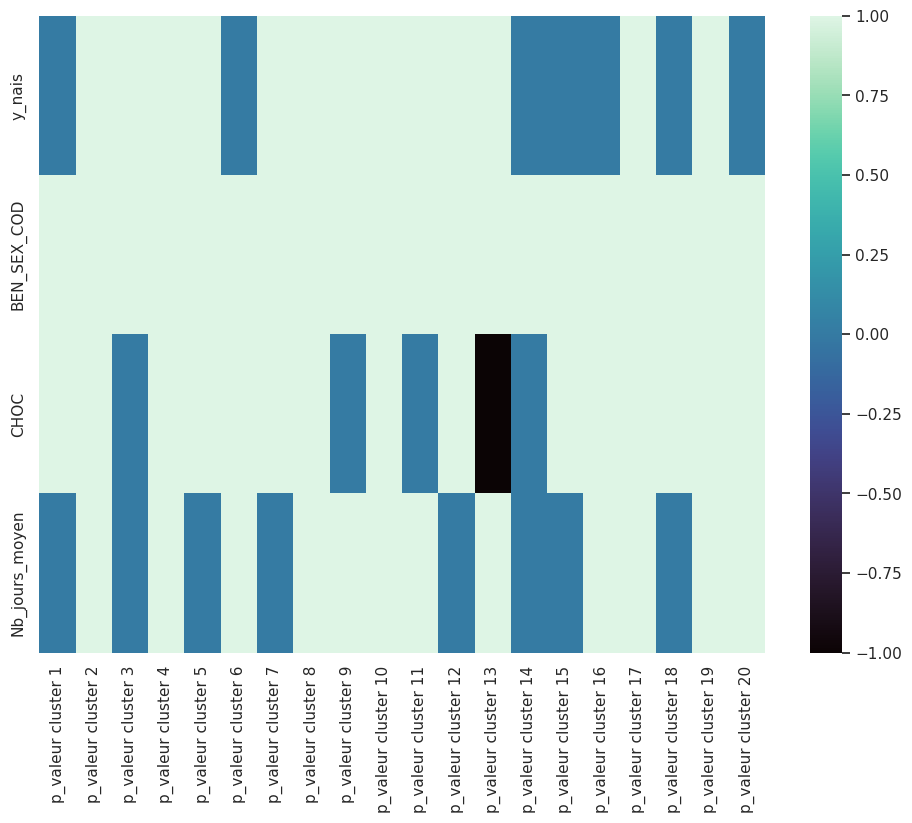

In [1382]:
sns.heatmap(KM_seuil, cmap="mako")

### Plot Intersection

In [1383]:
Intersection =KM_seuil.astype(int).values+ Rank_seuil.astype(int).values + Liste_ljung_box_seuil.astype(int).values
Intersection

array([[ 1,  3,  3,  2,  3,  1,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,
         3,  1,  3,  1],
       [ 2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3],
       [ 3,  3,  1,  3,  3,  2,  2,  3,  1,  3,  1,  3, -3,  0,  2,  2,
         3,  2,  3,  3],
       [ 0,  3,  1,  3,  0,  3,  1,  2,  3,  3,  3,  1,  3,  1,  1,  3,
         2,  1,  3,  3]])

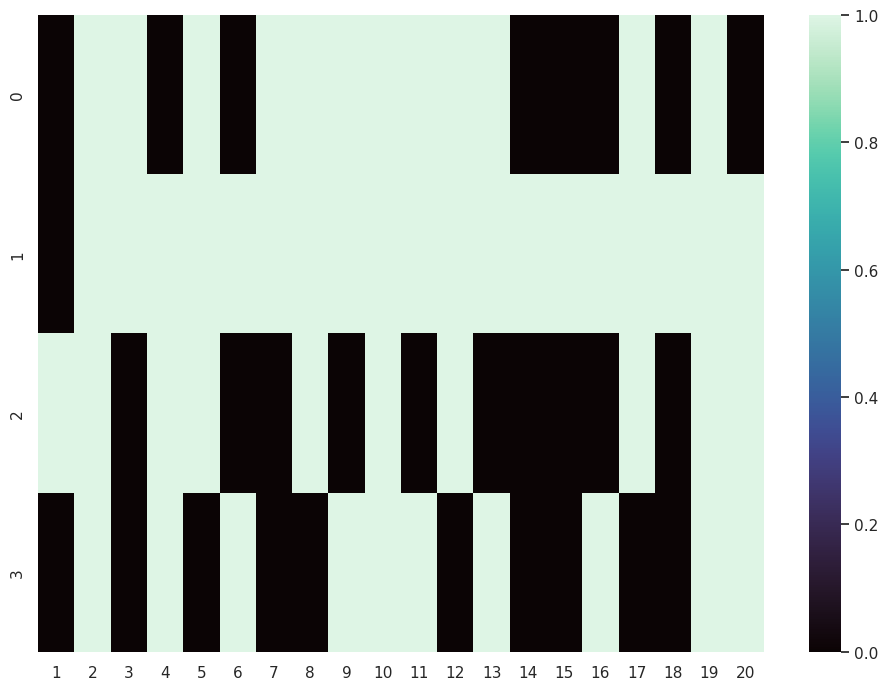

In [1384]:
ax=sns.heatmap(Intersection==3, cmap="mako")
ax.set_xticklabels(range(1,21))
plt.show()